In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import scale
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from tensorflow.keras import Model ,models, layers, optimizers, utils, losses
import tensorflow as tf

from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

import warnings
warnings.filterwarnings('ignore')

# 상관계수
import scipy.stats as stats

# 분산분석
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# 사후분석
from statsmodels.sandbox.stats.multicomp import MultiComparison

%matplotlib inline
plt.rcParams['figure.figsize'] = [25,12]
pd.options.display.float_format = '{:.3f}'.format

In [16]:
sqci=pd.read_csv('DC90_29900B_time_raw.csv')

## EDA

In [3]:
sqci.head()

,INSP_DTL_SEQ,INSP_CODE,INSP_DTL_CODE,VALUE,HEADER,IP_ADDRESS,PROD_SN,START_TIME,END_TIME,PASS_YN,INSP_NUM
0,0,RT02,AD01,0.000,CPC,0.0.0.102,39DC9029900B620ARAN0001,20211022115325,20211022115430,Y,2
1,1,RT02,AD01,0.000,CPC,0.0.0.102,39DC9029900B620ARAN0001,20211022115325,20211022115430,Y,2
2,2,RT02,AD01,7.000,CPC,0.0.0.102,39DC9029900B620ARAN0001,20211022115325,20211022115430,Y,2
3,3,RT02,AD01,36.000,CPC,0.0.0.102,39DC9029900B620ARAN0001,20211022115325,20211022115430,Y,2
4,4,RT02,AD01,36.000,CPC,0.0.0.102,39DC9029900B620ARAN0001,20211022115325,20211022115430,Y,2


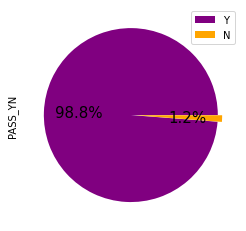

In [4]:
plt.figure(figsize = (6,4))

sqci['PASS_YN'].value_counts().plot(kind='pie', labels = ['',''],autopct='%1.1f%%',
                                 colors = ['purple', 'orange'], explode = [0,0.05],
                                 textprops = {'fontsize':15})
plt.legend(labels = ['Y', 'N'])
plt.show()

In [78]:
sqci.describe(include = 'all')

,INSP_DTL_SEQ,INSP_CODE,INSP_DTL_CODE,VALUE,HEADER,IP_ADDRESS,PROD_SN,START_TIME,END_TIME,PASS_YN,INSP_NUM,DURATION_TIME
count,700384.000,700384,700384,700384.000,700384,700384,700384,700384.000,700384.000,700384,700384.000,700384.000
unique,NaN,1,2,NaN,1,1,5233,NaN,NaN,2,NaN,NaN
top,NaN,RT02,AD01,NaN,CPC,0.0.0.102,39DC9029900B620ARAX0410,NaN,NaN,Y,NaN,NaN
freq,NaN,700384,350192,NaN,700384,700384,660,NaN,NaN,691826,NaN,NaN
mean,32.486,NaN,NaN,234.553,NaN,NaN,NaN,20211098366442.523,20211098366624.426,NaN,2.000,181.903
std,19.053,NaN,NaN,254.749,NaN,NaN,NaN,58351824.643,58351816.512,NaN,0.000,536.578
min,0.000,NaN,NaN,-145.100,NaN,NaN,NaN,20211022115325.000,20211022115430.000,NaN,2.000,3.000
25%,16.000,NaN,NaN,8.700,NaN,NaN,NaN,20211030012740.000,20211030012845.000,NaN,2.000,105.000
50%,32.000,NaN,NaN,19.000,NaN,NaN,NaN,20211110084429.000,20211110084535.000,NaN,2.000,105.000
75%,49.000,NaN,NaN,528.000,NaN,NaN,NaN,20211111165331.000,20211111165436.000,NaN,2.000,106.000


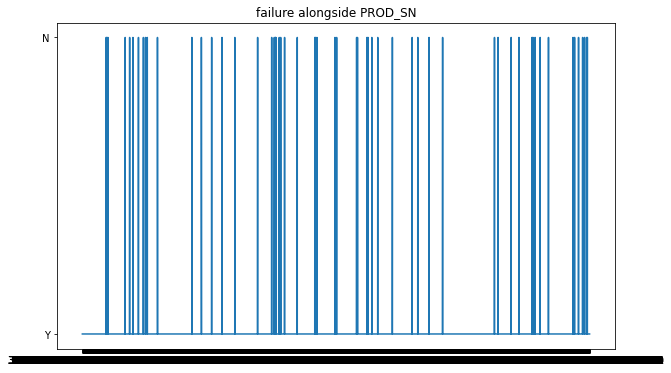

In [70]:
plt.figure(figsize=(10,6))
plt.plot(sqci['PROD_SN'],sqci['PASS_YN'])
plt.title('failure alongside PROD_SN')
plt.show()

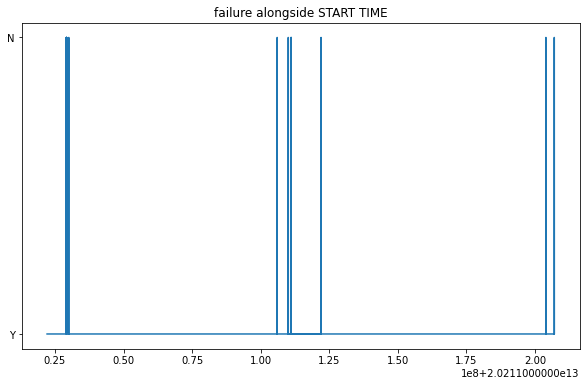

In [71]:
plt.figure(figsize=(10,6))
plt.plot(sqci['START_TIME'],sqci['PASS_YN'])
plt.title('failure alongside START TIME')
plt.show()

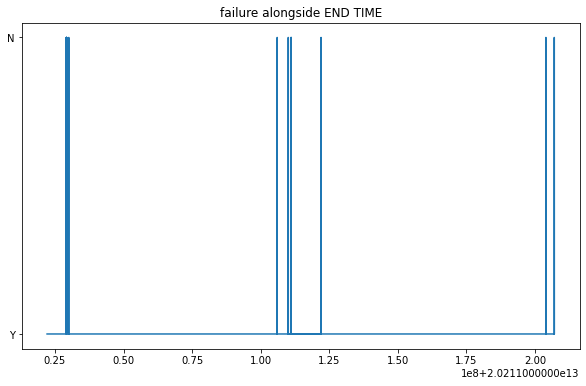

In [72]:
plt.figure(figsize=(10,6))
plt.plot(sqci['END_TIME'],sqci['PASS_YN'])
plt.title('failure alongside END TIME')
plt.show()

In [6]:
# 소요시간을 알고싶음
sqci['DURATION_TIME'] = sqci['END_TIME'] - sqci['START_TIME']

In [7]:
# 변수 선택
sqci1 = sqci[['INSP_DTL_SEQ', 'INSP_DTL_CODE', 'VALUE', 'PROD_SN', 'DURATION_TIME', 'PASS_YN']]

* 알고싶은 것 : 각 시리얼 넘버 당 time series 별 value 값 변화

In [8]:
# 시리얼 넘버 리스트화
prod_sn = sqci['PROD_SN'].unique()
prod_sn = prod_sn.tolist()

In [9]:
prod_sn
print(len(prod_sn))

5233


In [10]:
# value 추이를 알아보고 싶어서 조건에 맞는 일부 시리얼 넘버들 추출
# 01, 02, 03, 04, 26 = Y만 있음, 20 : N만 있음, 13, 98 : N, Y 둘 다 있음
sqci1_an0001 = sqci1[sqci1['PROD_SN'] == '39DC9029900B620ARAN0001']
sqci1_an0002 = sqci1[sqci1['PROD_SN'] == '39DC9029900B620ARAN0002']
sqci1_an0003 = sqci1[sqci1['PROD_SN'] == '39DC9029900B620ARAN0003']
sqci1_an0004 = sqci1[sqci1['PROD_SN'] == '39DC9029900B620ARAN0004']
sqci1_ax0013_n = sqci1[(sqci1['PROD_SN'] == '39DC9029900B620ARAX0013') & (sqci1['PASS_YN'] == 'N')]
sqci1_ax0013_y = sqci1[(sqci1['PROD_SN'] == '39DC9029900B620ARAX0013') & (sqci1['PASS_YN'] == 'Y')]
sqci1_ax0020 = sqci1[sqci1['PROD_SN'] == '39DC9029900B620ARAX0020']
sqci1_ax0026 = sqci1[sqci1['PROD_SN'] == '39DC9029900B620ARAX0026']
sqci1_B50098_n = sqci1[(sqci1['PROD_SN'] == '39DC9029900B620ARB50098') & (sqci1['PASS_YN'] == 'N')]
sqci1_B50098_y = sqci1[(sqci1['PROD_SN'] == '39DC9029900B620ARB50098') & (sqci1['PASS_YN'] == 'Y')]


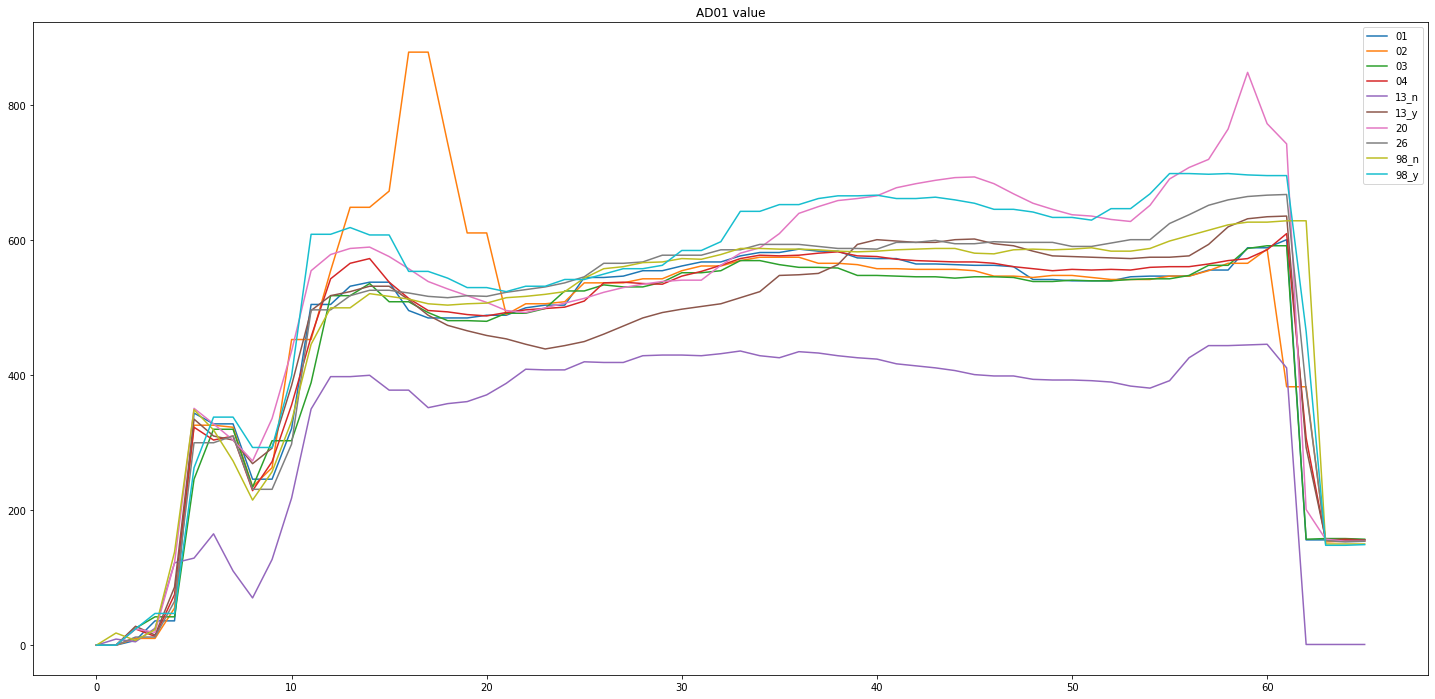

In [11]:
# AD01
x01 = sqci1_an0001['INSP_DTL_SEQ'][sqci1_an0001['INSP_DTL_CODE'] == 'AD01']
x02 = sqci1_an0002['INSP_DTL_SEQ'][sqci1_an0002['INSP_DTL_CODE'] == 'AD01']
x03 = sqci1_an0003['INSP_DTL_SEQ'][sqci1_an0003['INSP_DTL_CODE'] == 'AD01']
x04 = sqci1_an0004['INSP_DTL_SEQ'][sqci1_an0004['INSP_DTL_CODE'] == 'AD01']
x13_n = sqci1_ax0013_n['INSP_DTL_SEQ'][sqci1_ax0013_n['INSP_DTL_CODE'] == 'AD01']
x13_y = sqci1_ax0013_y['INSP_DTL_SEQ'][sqci1_ax0013_y['INSP_DTL_CODE'] == 'AD01']
x20 = sqci1_ax0020['INSP_DTL_SEQ'][(sqci1_ax0020['INSP_DTL_CODE'] == 'AD01') & (sqci1_ax0020['DURATION_TIME'] == 105)]
x26 = sqci1_ax0026['INSP_DTL_SEQ'][sqci1_ax0026['INSP_DTL_CODE'] == 'AD01']
x98_n = sqci1_B50098_n['INSP_DTL_SEQ'][sqci1_B50098_n['INSP_DTL_CODE'] == 'AD01']
x98_y = sqci1_B50098_y['INSP_DTL_SEQ'][sqci1_B50098_y['INSP_DTL_CODE'] == 'AD01']

y01 = sqci1_an0001['VALUE'][sqci1_an0001['INSP_DTL_CODE'] == 'AD01']
y02 = sqci1_an0002['VALUE'][sqci1_an0002['INSP_DTL_CODE'] == 'AD01']
y03 = sqci1_an0003['VALUE'][sqci1_an0003['INSP_DTL_CODE'] == 'AD01']
y04 = sqci1_an0004['VALUE'][sqci1_an0004['INSP_DTL_CODE'] == 'AD01']
y13_n = sqci1_ax0013_n['VALUE'][sqci1_ax0013_n['INSP_DTL_CODE'] == 'AD01']
y13_y = sqci1_ax0013_y['VALUE'][sqci1_ax0013_y['INSP_DTL_CODE'] == 'AD01']
y20 = sqci1_ax0020['VALUE'][(sqci1_ax0020['INSP_DTL_CODE'] == 'AD01') & (sqci1_ax0020['DURATION_TIME'] == 105)]
y26 = sqci1_ax0026['VALUE'][sqci1_ax0026['INSP_DTL_CODE'] == 'AD01']
y98_n = sqci1_B50098_n['VALUE'][sqci1_B50098_n['INSP_DTL_CODE'] == 'AD01']
y98_y = sqci1_B50098_y['VALUE'][sqci1_B50098_y['INSP_DTL_CODE'] == 'AD01']

legend = ['01', '02', '03', '04', '13_n', '13_y', '20', '26', '98_n', '98_y']

plt.plot(x01, y01) # Y
plt.plot(x02, y02) # Y
plt.plot(x03, y03) # Y
plt.plot(x04, y04) # Y
plt.plot(x13_n, y13_n) # N
plt.plot(x13_y, y13_y) # Y
plt.plot(x20, y20) # N
plt.plot(x26, y26) # Y
plt.plot(x98_n, y98_n) # N
plt.plot(x98_y, y98_y) # Y
plt.title('AD01 value')
plt.legend(legend)
plt.show()

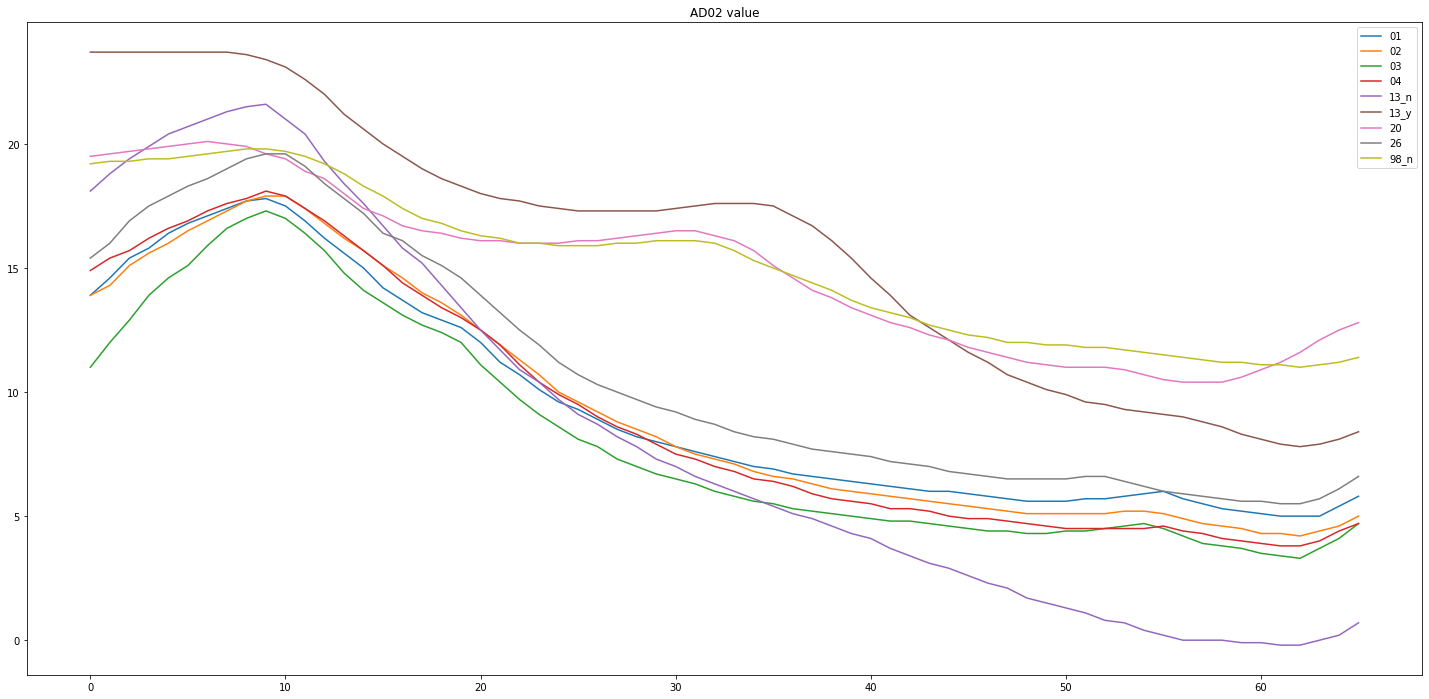

In [12]:
# AD02
x01 = sqci1_an0001['INSP_DTL_SEQ'][sqci1_an0001['INSP_DTL_CODE'] == 'AD02']
x02 = sqci1_an0002['INSP_DTL_SEQ'][sqci1_an0002['INSP_DTL_CODE'] == 'AD02']
x03 = sqci1_an0003['INSP_DTL_SEQ'][sqci1_an0003['INSP_DTL_CODE'] == 'AD02']
x04 = sqci1_an0004['INSP_DTL_SEQ'][sqci1_an0004['INSP_DTL_CODE'] == 'AD02']
x13_n = sqci1_ax0013_n['INSP_DTL_SEQ'][sqci1_ax0013_n['INSP_DTL_CODE'] == 'AD02']
x13_y = sqci1_ax0013_y['INSP_DTL_SEQ'][sqci1_ax0013_y['INSP_DTL_CODE'] == 'AD02']
x20 = sqci1_ax0020['INSP_DTL_SEQ'][(sqci1_ax0020['INSP_DTL_CODE'] == 'AD02') & (sqci1_ax0020['DURATION_TIME'] == 105)]
x26 = sqci1_ax0026['INSP_DTL_SEQ'][sqci1_ax0026['INSP_DTL_CODE'] == 'AD02']
x98_n = sqci1_B50098_n['INSP_DTL_SEQ'][sqci1_B50098_n['INSP_DTL_CODE'] == 'AD02']
x98_y = sqci1_B50098_y['INSP_DTL_SEQ'][sqci1_B50098_y['INSP_DTL_CODE'] == 'AD02']

y01 = sqci1_an0001['VALUE'][sqci1_an0001['INSP_DTL_CODE'] == 'AD02']
y02 = sqci1_an0002['VALUE'][sqci1_an0002['INSP_DTL_CODE'] == 'AD02']
y03 = sqci1_an0003['VALUE'][sqci1_an0003['INSP_DTL_CODE'] == 'AD02']
y04 = sqci1_an0004['VALUE'][sqci1_an0004['INSP_DTL_CODE'] == 'AD02']
y13_n = sqci1_ax0013_n['VALUE'][sqci1_ax0013_n['INSP_DTL_CODE'] == 'AD02']
y13_y = sqci1_ax0013_y['VALUE'][sqci1_ax0013_y['INSP_DTL_CODE'] == 'AD02']
y20 = sqci1_ax0020['VALUE'][(sqci1_ax0020['INSP_DTL_CODE'] == 'AD02') & (sqci1_ax0020['DURATION_TIME'] == 105)]
y26 = sqci1_ax0026['VALUE'][sqci1_ax0026['INSP_DTL_CODE'] == 'AD02']
y98_n = sqci1_B50098_n['VALUE'][sqci1_B50098_n['INSP_DTL_CODE'] == 'AD02']
y98_y = sqci1_B50098_y['VALUE'][sqci1_B50098_y['INSP_DTL_CODE'] == 'AD02']

legend = ['01', '02', '03', '04', '13_n', '13_y', '20', '26', '98_n', '98_y']

plt.plot(x01, y01) # Y
plt.plot(x02, y02) # Y
plt.plot(x03, y03) # Y
plt.plot(x04, y04) # Y
plt.plot(x13_n, y13_n) # N
plt.plot(x13_y, y13_y) # Y
plt.plot(x20, y20) # N
plt.plot(x26, y26) # Y
#plt.plot(x98_n, y98_n) # N
plt.plot(x98_y, y98_y) # Y
plt.title('AD02 value')
plt.legend(legend)
plt.show()

## 1. PASS_YN 히스토그램 표현

<AxesSubplot:xlabel='INSP_DTL_SEQ'>

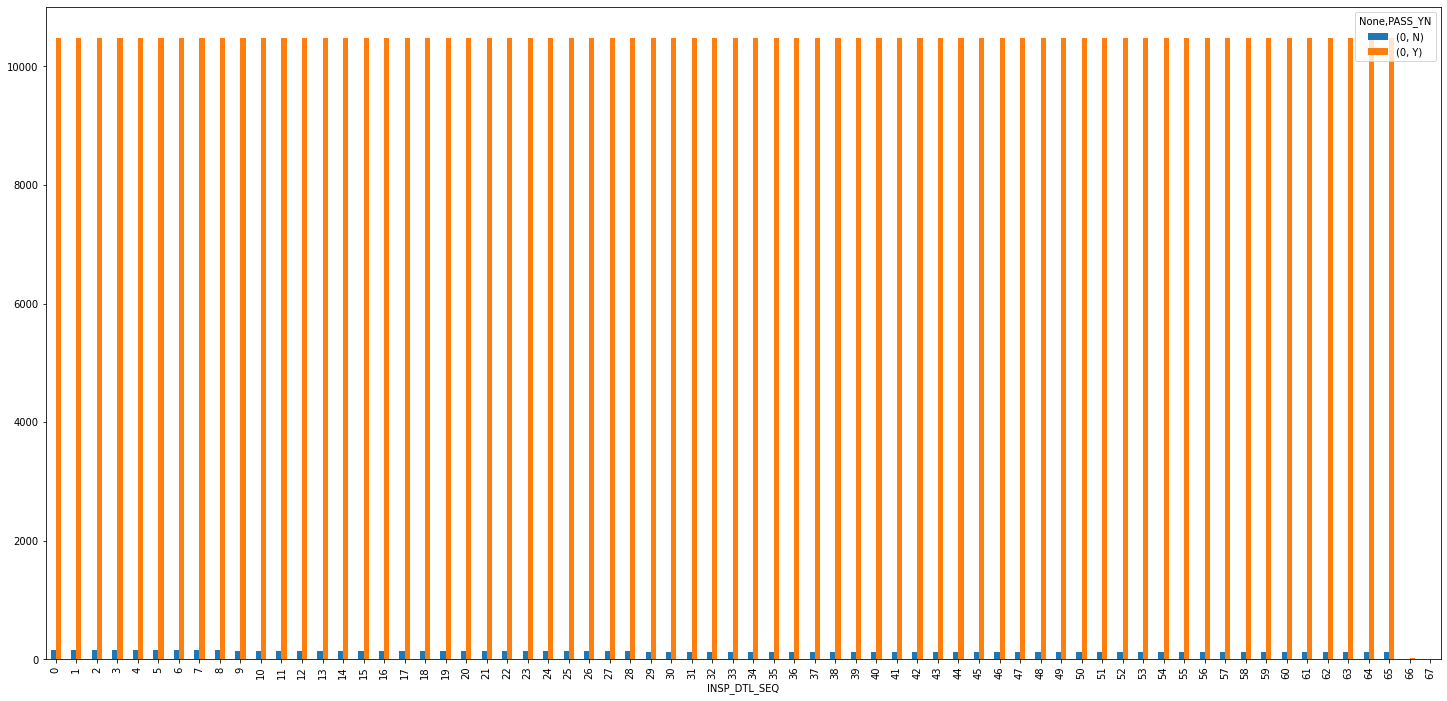

In [41]:
# INSP_DTL_SEQ 별 pass_yn 갯수 표현

pass_yn=sqci1.groupby(['INSP_DTL_SEQ','PASS_YN']).size()
PASS_YN=pd.DataFrame(pass_yn)
PASS_YN.unstack().plot(kind = 'bar')

<AxesSubplot:xlabel='INSP_DTL_SEQ'>

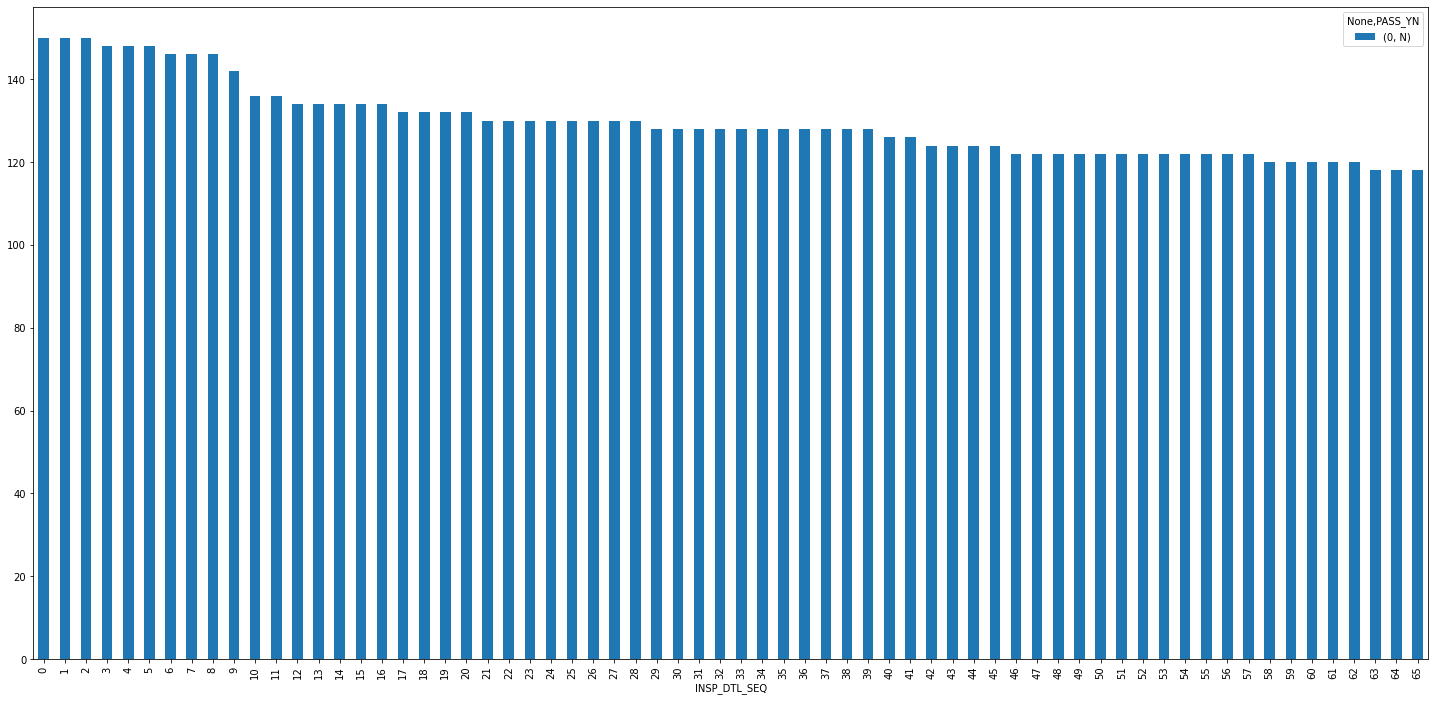

In [42]:
# N
pass_yn_n = sqci1[sqci1['PASS_YN'] == 'N']
pass_yn_n = pass_yn_n.groupby(['INSP_DTL_SEQ', 'PASS_YN']).size()
PASS_YN_N = pd.DataFrame(pass_yn_n)

PASS_YN_N.unstack().plot(kind = 'bar')

In [43]:
PASS_YN_N

,,0
INSP_DTL_SEQ,PASS_YN,
0,N,150
1,N,150
2,N,150
3,N,148
4,N,148
...,...,...
61,N,120
62,N,120
63,N,118


<AxesSubplot:xlabel='INSP_DTL_SEQ'>

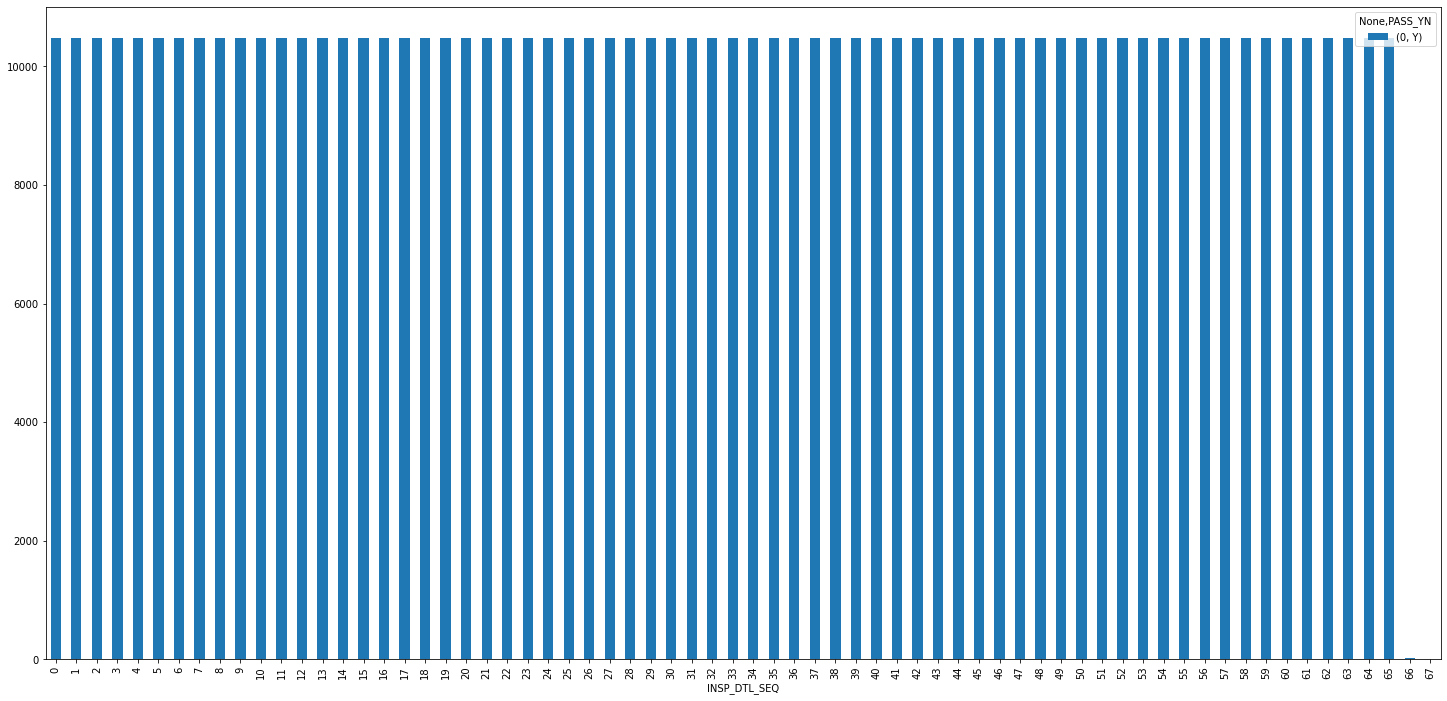

In [44]:
# Y
pass_yn_y = sqci1[sqci1['PASS_YN'] == 'Y']
pass_yn_y = pass_yn_y.groupby(['INSP_DTL_SEQ', 'PASS_YN']).size()
PASS_YN_Y = pd.DataFrame(pass_yn_y)

PASS_YN_Y.unstack().plot(kind = 'bar')

In [45]:
PASS_YN_Y = PASS_YN_Y[0:66]
PASS_YN_Y

,,0
INSP_DTL_SEQ,PASS_YN,
0,Y,10482
1,Y,10482
2,Y,10482
3,Y,10482
4,Y,10482
...,...,...
61,Y,10482
62,Y,10482
63,Y,10482


In [46]:
# N : Y 비율

PASS_YN_MERGE = pd.merge(PASS_YN_N, PASS_YN_Y, how = 'outer', on = 'INSP_DTL_SEQ')
PASS_YN_MERGE.columns
PASS_YN_MERGE.rename(columns = {'0_x' : 'pass_n', '0_y' : 'pass_y'}, inplace = True)
PASS_YN_MERGE

,pass_n,pass_y
INSP_DTL_SEQ,,
0,150,10482
1,150,10482
2,150,10482
3,148,10482
4,148,10482
...,...,...
61,120,10482
62,120,10482
63,118,10482


In [370]:
PASS_YN_MERGE['ratio']= round(PASS_YN_MERGE['pass_n'] / (PASS_YN_MERGE['pass_y'] + PASS_YN_MERGE['pass_n']) * 100, 2)
PASS_YN_MERGE.reset_index(inplace = True)
PASS_YN_MERGE

,level_0,index,INSP_DTL_SEQ,pass_n,pass_y,ratio
0,0,0,0,150,10482,1.410
1,1,1,1,150,10482,1.410
2,2,2,2,150,10482,1.410
3,3,3,3,148,10482,1.390
4,4,4,4,148,10482,1.390
...,...,...,...,...,...,...
61,61,61,61,120,10482,1.130
62,62,62,62,120,10482,1.130
63,63,63,63,118,10482,1.110
64,64,64,64,118,10482,1.110


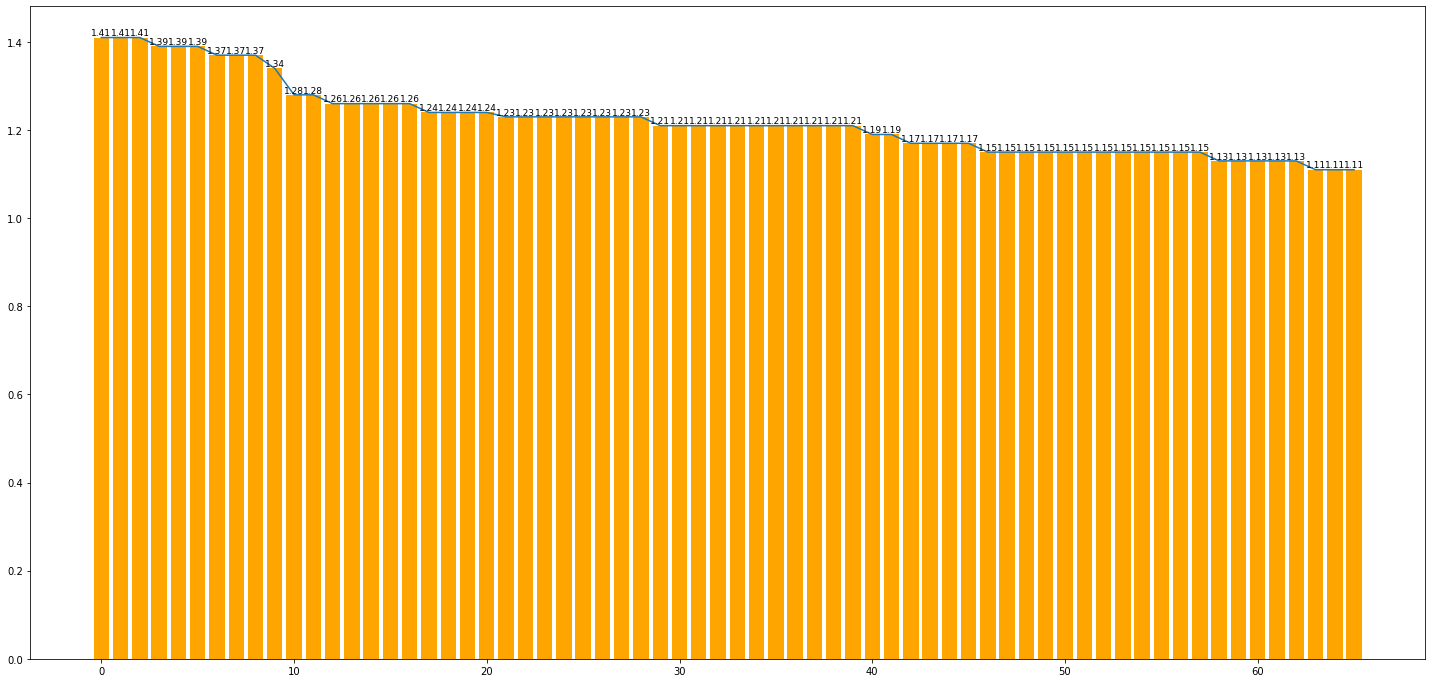

In [371]:
x = PASS_YN_MERGE['INSP_DTL_SEQ']
y = PASS_YN_MERGE['ratio']
plt.bar(x, y, color= 'orange')
plt.plot(x, y)

for i, v in enumerate(x):
    plt.text(v, y[i], y[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 9, 
             color='black',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)

plt.show()

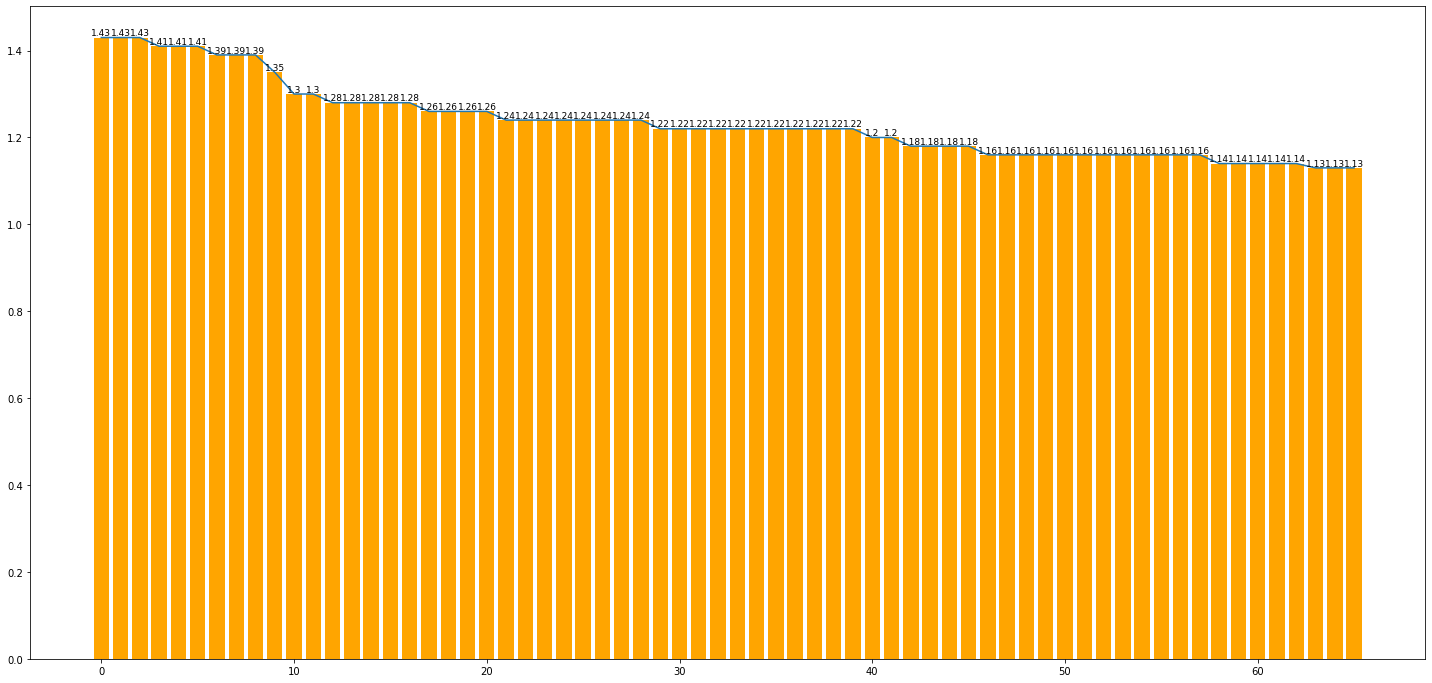

In [48]:
x = PASS_YN_MERGE['INSP_DTL_SEQ']
y = PASS_YN_MERGE['ratio']
plt.bar(x, y, color= 'orange')
plt.plot(x, y)

for i, v in enumerate(x):
    plt.text(v, y[i], y[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 9, 
             color='black',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)

plt.show()

In [3]:
sqci.columns

Index(['INSP_DTL_SEQ', 'INSP_CODE', 'INSP_DTL_CODE', 'VALUE', 'HEADER',
       'IP_ADDRESS', 'PROD_SN', 'START_TIME', 'END_TIME', 'PASS_YN',
       'INSP_NUM'],
      dtype='object')

In [7]:
AD01=sqci.where(sqci['INSP_DTL_CODE']=='AD01')


In [8]:
AD01.head()

,INSP_DTL_SEQ,INSP_CODE,INSP_DTL_CODE,VALUE,HEADER,IP_ADDRESS,PROD_SN,START_TIME,END_TIME,PASS_YN,INSP_NUM
0,0.000,RT02,AD01,0.000,CPC,0.0.0.102,39DC9029900B620ARAN0001,20211022115325.000,20211022115430.000,Y,2.000
1,1.000,RT02,AD01,0.000,CPC,0.0.0.102,39DC9029900B620ARAN0001,20211022115325.000,20211022115430.000,Y,2.000
2,2.000,RT02,AD01,7.000,CPC,0.0.0.102,39DC9029900B620ARAN0001,20211022115325.000,20211022115430.000,Y,2.000
3,3.000,RT02,AD01,36.000,CPC,0.0.0.102,39DC9029900B620ARAN0001,20211022115325.000,20211022115430.000,Y,2.000
4,4.000,RT02,AD01,36.000,CPC,0.0.0.102,39DC9029900B620ARAN0001,20211022115325.000,20211022115430.000,Y,2.000


In [22]:
AD02=sqci.where(sqci['INSP_DTL_CODE']=='AD02')
AD02.head()

,INSP_DTL_SEQ,INSP_CODE,INSP_DTL_CODE,VALUE,HEADER,IP_ADDRESS,PROD_SN,START_TIME,END_TIME,PASS_YN,INSP_NUM
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
AD01=sqci.loc[sqci['INSP_DTL_CODE']=='AD01',:]
AD02=sqci.loc[sqci['INSP_DTL_CODE']=='AD02',:]

In [21]:
sqci['INSP_DTL_CODE'].unique()

array(['AD01', 'AD02'], dtype=object)

In [19]:
AD02.isnull().sum()

INSP_DTL_SEQ     350192
INSP_CODE        350192
INSP_DTL_CODE    350192
VALUE            350192
HEADER           350192
IP_ADDRESS       350192
PROD_SN          350192
START_TIME       350192
END_TIME         350192
PASS_YN          350192
INSP_NUM         350192
dtype: int64

In [28]:
AD02.head()

,INSP_DTL_SEQ,INSP_CODE,INSP_DTL_CODE,VALUE,HEADER,IP_ADDRESS,PROD_SN,START_TIME,END_TIME,PASS_YN,INSP_NUM
66,0,RT02,AD02,13.900,CPC,0.0.0.102,39DC9029900B620ARAN0001,20211022115325,20211022115430,Y,2
67,1,RT02,AD02,14.600,CPC,0.0.0.102,39DC9029900B620ARAN0001,20211022115325,20211022115430,Y,2
68,2,RT02,AD02,15.400,CPC,0.0.0.102,39DC9029900B620ARAN0001,20211022115325,20211022115430,Y,2
69,3,RT02,AD02,15.800,CPC,0.0.0.102,39DC9029900B620ARAN0001,20211022115325,20211022115430,Y,2
70,4,RT02,AD02,16.400,CPC,0.0.0.102,39DC9029900B620ARAN0001,20211022115325,20211022115430,Y,2


In [10]:
import seaborn as sns

<AxesSubplot:xlabel='VALUE', ylabel='Count'>

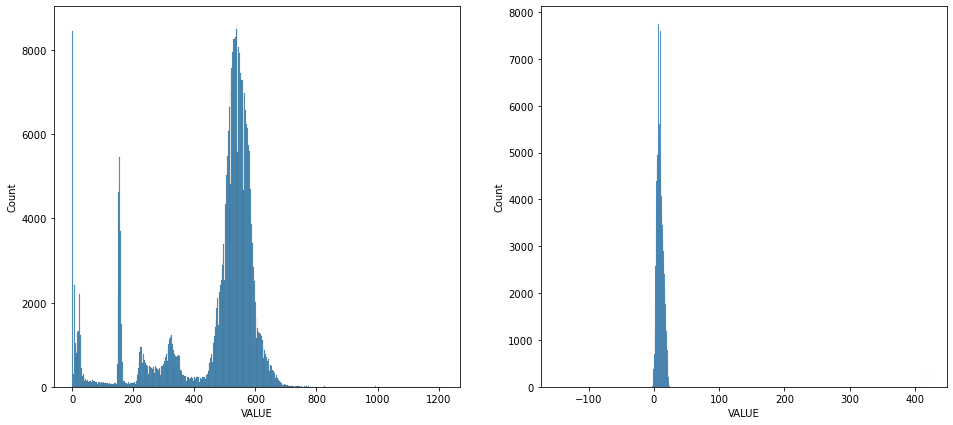

In [30]:
fig=plt.figure(figsize=(16,7))
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
sns.histplot(AD01['VALUE'],ax=ax1)
sns.histplot(AD02['VALUE'],ax=ax2)

In [38]:
AD01.groupby(['PASS_YN'])['VALUE'].describe(include='all')

,count,mean,std,min,25%,50%,75%,max
PASS_YN,,,,,,,,
N,4279.000,371.359,226.589,0.000,163.000,379.000,535.000,1208.000
Y,345913.000,460.182,168.567,0.000,465.000,528.000,561.000,879.000


In [43]:
AD02.groupby(['PASS_YN'])['VALUE'].describe(include='all')

,count,mean,std,min,25%,50%,75%,max
PASS_YN,,,,,,,,
N,4279.000,36.594,97.159,-145.100,8.200,13.100,16.700,420.000
Y,345913.000,9.681,6.450,-2.400,5.800,9.100,13.000,420.000


In [41]:
ad02_mean=sqci['VALUE'].mean()
ad02_std=sqci['VALUE'].std()

In [45]:
AD02[['VALUE']].describe()

,VALUE
count,350192.000
mean,10.010
std,12.851
min,-145.100
25%,5.800
50%,9.200
75%,13.100
max,420.000


In [57]:
AD02['failure']=0
AD02['failure']=np.where((AD02['VALUE']>=(ad02_mean+ad02_std)) | (AD02['VALUE']<=(ad02_mean-ad02_std)),'N','Y')

In [58]:
AD02.head()

,INSP_DTL_SEQ,INSP_CODE,INSP_DTL_CODE,VALUE,HEADER,IP_ADDRESS,PROD_SN,START_TIME,END_TIME,PASS_YN,INSP_NUM,failure
66,0,RT02,AD02,13.900,CPC,0.0.0.102,39DC9029900B620ARAN0001,20211022115325,20211022115430,Y,2,Y
67,1,RT02,AD02,14.600,CPC,0.0.0.102,39DC9029900B620ARAN0001,20211022115325,20211022115430,Y,2,Y
68,2,RT02,AD02,15.400,CPC,0.0.0.102,39DC9029900B620ARAN0001,20211022115325,20211022115430,Y,2,Y
69,3,RT02,AD02,15.800,CPC,0.0.0.102,39DC9029900B620ARAN0001,20211022115325,20211022115430,Y,2,Y
70,4,RT02,AD02,16.400,CPC,0.0.0.102,39DC9029900B620ARAN0001,20211022115325,20211022115430,Y,2,Y


In [62]:
TRUE=(AD02['PASS_YN']==AD02['failure'])


In [80]:
TRUE = pd.DataFrame(TRUE)


In [86]:
TRUE[TRUE[0] == True]

,0
66,True
67,True
68,True
69,True
70,True
...,...
700379,True
700380,True
700381,True
700382,True


In [78]:
TRUE.unique()

array([ True, False])

In [73]:
len(AD02['failure'])

350192

In [87]:
len(TRUE[TRUE[0] == True])

345922

In [88]:
accuracy=len(TRUE[TRUE[0] == True])/len(AD02['failure'])

In [89]:
accuracy

0.987806688902088

In [40]:
sqci[(sqci['VALUE'] >= 700)]

,INSP_DTL_SEQ,INSP_CODE,INSP_DTL_CODE,VALUE,HEADER,IP_ADDRESS,PROD_SN,START_TIME,END_TIME,PASS_YN,INSP_NUM
148,16,RT02,AD01,879.000,CPC,0.0.0.102,39DC9029900B620ARAN0002,20211022115348,20211022115454,Y,2
149,17,RT02,AD01,879.000,CPC,0.0.0.102,39DC9029900B620ARAN0002,20211022115348,20211022115454,Y,2
150,18,RT02,AD01,744.000,CPC,0.0.0.102,39DC9029900B620ARAN0002,20211022115348,20211022115454,Y,2
9246,6,RT02,AD01,775.000,CPC,0.0.0.102,39DC9029900B620ARAN0071,20211022131512,20211022131617,Y,2
33564,36,RT02,AD01,858.000,CPC,0.0.0.102,39DC9029900B620ARAX0020,20211029182247,20211029182343,N,2
...,...,...,...,...,...,...,...,...,...,...,...
563736,12,RT02,AD01,751.000,CPC,0.0.0.102,39DC9029900B620ARBM0104,20211122035036,20211122035142,Y,2
563783,59,RT02,AD01,701.000,CPC,0.0.0.102,39DC9029900B620ARBM0104,20211122035036,20211122035142,Y,2
563784,60,RT02,AD01,701.000,CPC,0.0.0.102,39DC9029900B620ARBM0104,20211122035036,20211122035142,Y,2
563785,61,RT02,AD01,703.000,CPC,0.0.0.102,39DC9029900B620ARBM0104,20211122035036,20211122035142,Y,2


In [39]:
sqci.where(sqci['VALUE']>=700)

,INSP_DTL_SEQ,INSP_CODE,INSP_DTL_CODE,VALUE,HEADER,IP_ADDRESS,PROD_SN,START_TIME,END_TIME,PASS_YN,INSP_NUM
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
700379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
700380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
700381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
700382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
pd.pivot_table(sqci,columns=['INSP_DTL_CODE','PROD_SN'],values=['VALUE'],aggfunc=['min','mean','std','max'])

min                          \
INSP_DTL_CODE                    AD01                           
PROD_SN       39DC9029900B620ARAN0001 39DC9029900B620ARAN0002   
VALUE                           0.000                   0.000   

                                                               \
INSP_DTL_CODE                                                   
PROD_SN       39DC9029900B620ARAN0003 39DC9029900B620ARAN0004   
VALUE                           0.000                   0.000   

                                                               \
INSP_DTL_CODE                                                   
PROD_SN       39DC9029900B620ARAN0005 39DC9029900B620ARAN0006   
VALUE                           0.000                   0.000   

                                                               \
INSP_DTL_CODE                                                   
PROD_SN       39DC9029900B620ARAN0007 39DC9029900B620ARAN0008   
VALUE                           0.000                   0.000   

                                                               ...  \
INSP_DTL_CODE                                                  ...   
PROD_SN       39DC9029900B620ARAN0009 39DC9029900B620ARAN0010  ...   
VALUE                           0.000                   0.000  ...   

                                  max                          \
INSP_DTL_CODE                    AD02                           
PROD_SN       39DC9029900B620ARC70303 39DC9029900B620ARC70304   
VALUE                          12.800                  14.700   

                                                               \
INSP_DTL_CODE                                                   
PROD_SN       39DC9029900B620ARC70305 39DC9029900B620ARC70306   
VALUE                          18.700                  15.500   

                                                               \
INSP_DTL_CODE                                                   
PROD_SN       39DC9029900B620ARC70307 39DC9029900B620ARC70308   
VALUE                          14.700                  13.200   

                                                               \
INSP_DTL_CODE                                                   
PROD_SN       39DC9029900B620ARC70309 39DC9029900B620ARC70310   
VALUE                          14.100                  13.800   

                                                               
INSP_DTL_CODE                                                  
PROD_SN       39DC9029900B620ARC70311 39DC9029900B620ARC70312  
VALUE                          14.000                  14.300  

[1 rows x 41864 columns]

##  clustering - 500개 랜덤 추출

* 1) one - hot encoding
* 2) feature scaling
* 3) pca 분석 후 차원 축소 노력

In [61]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

###  메모리 부족때문에 unique한 prod_sn 500개 랜덤으로 추출

In [13]:
prod_sn1  = random.sample(prod_sn, 500)

In [14]:
# prod_sn1에만 있는 시리얼 넘버만 추출
sqci2 = sqci1[sqci1['PROD_SN'].isin(prod_sn1)]
sqci2

,INSP_DTL_SEQ,INSP_DTL_CODE,VALUE,PROD_SN,DURATION_TIME,PASS_YN
132,0,AD01,0.000,39DC9029900B620ARAN0002,106,Y
133,1,AD01,0.000,39DC9029900B620ARAN0002,106,Y
134,2,AD01,10.000,39DC9029900B620ARAN0002,106,Y
135,3,AD01,10.000,39DC9029900B620ARAN0002,106,Y
136,4,AD01,55.000,39DC9029900B620ARAN0002,106,Y
...,...,...,...,...,...,...
700115,61,AD02,4.000,39DC9029900B620ARC70310,105,Y
700116,62,AD02,4.000,39DC9029900B620ARC70310,105,Y
700117,63,AD02,4.100,39DC9029900B620ARC70310,105,Y
700118,64,AD02,4.200,39DC9029900B620ARC70310,105,Y


In [15]:
# pass 여부를 y,n -> 1,0으로 바꾸기
sqci2['PASS_YN'] = sqci2['PASS_YN'].map({'Y':1,
                                         'N':0})
sqci2

C:\Users\gky20\AppData\Local\Temp\ipykernel_18456\896996554.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sqci2['PASS_YN'] = sqci2['PASS_YN'].map({'Y':1,


,INSP_DTL_SEQ,INSP_DTL_CODE,VALUE,PROD_SN,DURATION_TIME,PASS_YN
132,0,AD01,0.000,39DC9029900B620ARAN0002,106,1
133,1,AD01,0.000,39DC9029900B620ARAN0002,106,1
134,2,AD01,10.000,39DC9029900B620ARAN0002,106,1
135,3,AD01,10.000,39DC9029900B620ARAN0002,106,1
136,4,AD01,55.000,39DC9029900B620ARAN0002,106,1
...,...,...,...,...,...,...
700115,61,AD02,4.000,39DC9029900B620ARC70310,105,1
700116,62,AD02,4.000,39DC9029900B620ARC70310,105,1
700117,63,AD02,4.100,39DC9029900B620ARC70310,105,1
700118,64,AD02,4.200,39DC9029900B620ARC70310,105,1


In [17]:
sqci2[sqci2['PASS_YN'] == 1].count()

INSP_DTL_SEQ     66000
INSP_DTL_CODE    66000
VALUE            66000
PROD_SN          66000
DURATION_TIME    66000
PASS_YN          66000
dtype: int64

In [18]:
# one - hot encoding
sqci2_onehot = pd.get_dummies(sqci2)
sqci2_onehot.head()

,INSP_DTL_SEQ,VALUE,DURATION_TIME,PASS_YN,INSP_DTL_CODE_AD01,INSP_DTL_CODE_AD02,PROD_SN_39DC9029900B620ARAN0002,PROD_SN_39DC9029900B620ARAN0004,PROD_SN_39DC9029900B620ARAN0021,PROD_SN_39DC9029900B620ARAN0027,...,PROD_SN_39DC9029900B620ARC70249,PROD_SN_39DC9029900B620ARC70256,PROD_SN_39DC9029900B620ARC70262,PROD_SN_39DC9029900B620ARC70264,PROD_SN_39DC9029900B620ARC70271,PROD_SN_39DC9029900B620ARC70282,PROD_SN_39DC9029900B620ARC70284,PROD_SN_39DC9029900B620ARC70288,PROD_SN_39DC9029900B620ARC70292,PROD_SN_39DC9029900B620ARC70310
132,0,0.000,106,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
133,1,0.000,106,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
134,2,10.000,106,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
135,3,10.000,106,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
136,4,55.000,106,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [516]:
# feature scaling

sc = StandardScaler()
sqci2_sc = sc.fit_transform(sqci2_onehot)
sqci2_sc = pd.DataFrame(sqci2_sc, columns = sqci2_onehot.columns)

In [517]:
sqci2_sc.tail()

,INSP_DTL_SEQ,VALUE,DURATION_TIME,PASS_YN,INSP_DTL_CODE_AD01,INSP_DTL_CODE_AD02,PROD_SN_39DC9029900B620ARAN0002,PROD_SN_39DC9029900B620ARAN0004,PROD_SN_39DC9029900B620ARAN0021,PROD_SN_39DC9029900B620ARAN0027,...,PROD_SN_39DC9029900B620ARC70249,PROD_SN_39DC9029900B620ARC70256,PROD_SN_39DC9029900B620ARC70262,PROD_SN_39DC9029900B620ARC70264,PROD_SN_39DC9029900B620ARC70271,PROD_SN_39DC9029900B620ARC70282,PROD_SN_39DC9029900B620ARC70284,PROD_SN_39DC9029900B620ARC70288,PROD_SN_39DC9029900B620ARC70292,PROD_SN_39DC9029900B620ARC70310
66543,1.496,-0.904,-0.141,0.091,-1.000,1.000,-0.045,-0.045,-0.045,-0.045,...,-0.045,-0.045,-0.045,-0.045,-0.045,-0.063,-0.045,-0.045,-0.045,22.431
66544,1.549,-0.904,-0.141,0.091,-1.000,1.000,-0.045,-0.045,-0.045,-0.045,...,-0.045,-0.045,-0.045,-0.045,-0.045,-0.063,-0.045,-0.045,-0.045,22.431
66545,1.601,-0.903,-0.141,0.091,-1.000,1.000,-0.045,-0.045,-0.045,-0.045,...,-0.045,-0.045,-0.045,-0.045,-0.045,-0.063,-0.045,-0.045,-0.045,22.431
66546,1.654,-0.903,-0.141,0.091,-1.000,1.000,-0.045,-0.045,-0.045,-0.045,...,-0.045,-0.045,-0.045,-0.045,-0.045,-0.063,-0.045,-0.045,-0.045,22.431
66547,1.706,-0.902,-0.141,0.091,-1.000,1.000,-0.045,-0.045,-0.045,-0.045,...,-0.045,-0.045,-0.045,-0.045,-0.045,-0.063,-0.045,-0.045,-0.045,22.431


In [518]:
# data split

target = sqci2_sc['PASS_YN']
features = sqci2_sc.drop(['PASS_YN'], axis = 'columns')

In [519]:
#pca

pca = PCA(random_state = 100)
sqci_pca = pca.fit_transform(features)
pd.Series(np.cumsum(pca.explained_variance_ratio_)).tail(45)

# 505 -> 500 차원으로 축소해도 됨 or 475개? (95.1% 설명 가능)

460   0.920
461   0.922
462   0.924
463   0.926
464   0.928
465   0.930
466   0.932
467   0.934
468   0.936
469   0.938
470   0.940
471   0.942
472   0.944
473   0.946
474   0.948
475   0.950
476   0.952
477   0.954
478   0.956
479   0.958
480   0.960
481   0.962
482   0.964
483   0.966
484   0.968
485   0.970
486   0.972
487   0.974
488   0.976
489   0.978
490   0.980
491   0.982
492   0.984
493   0.986
494   0.988
495   0.990
496   0.992
497   0.994
498   0.996
499   0.998
500   1.000
501   1.000
502   1.000
503   1.000
504   1.000
dtype: float64

In [520]:
# 95.0 % 설명 가능한 지점은 475번째 주성분 값
pca = PCA(n_components=475)
features_pca = pca.fit_transform(features)
np.cumsum(pca.explained_variance_ratio_)[-10:]

array([0.93028836, 0.9322725 , 0.93425663, 0.93624076, 0.9382249 ,
       0.94020903, 0.94219316, 0.9441773 , 0.94616143, 0.94814557])

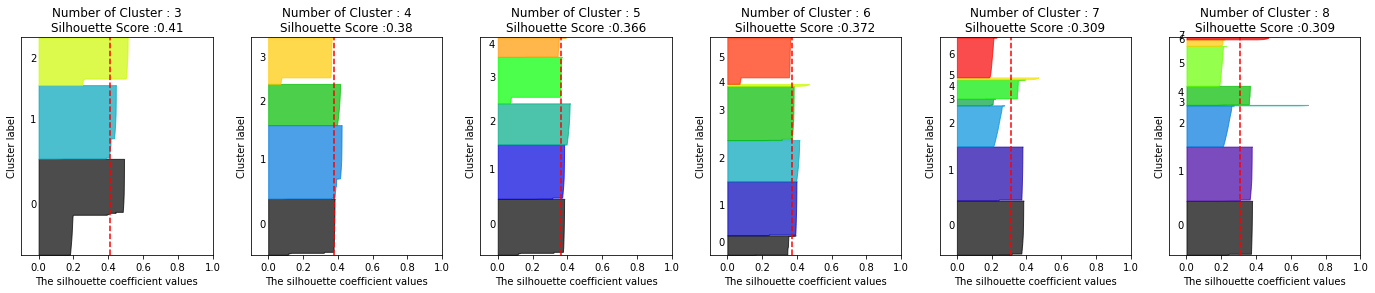

In [63]:
# cluster 몇개로 할건지?

visualize_silhouette([3,4,5,6,7,8], features)
# 4개 or 6개로 했을때 적절할 것 같음

In [521]:
wcss = []
for i in range(1, 10):
    kmeans_pca = KMeans(n_clusters=i, init = 'k-means++', random_state = 42 )
    kmeans_pca.fit(features_pca)
    wcss.append(kmeans_pca.inertia_)

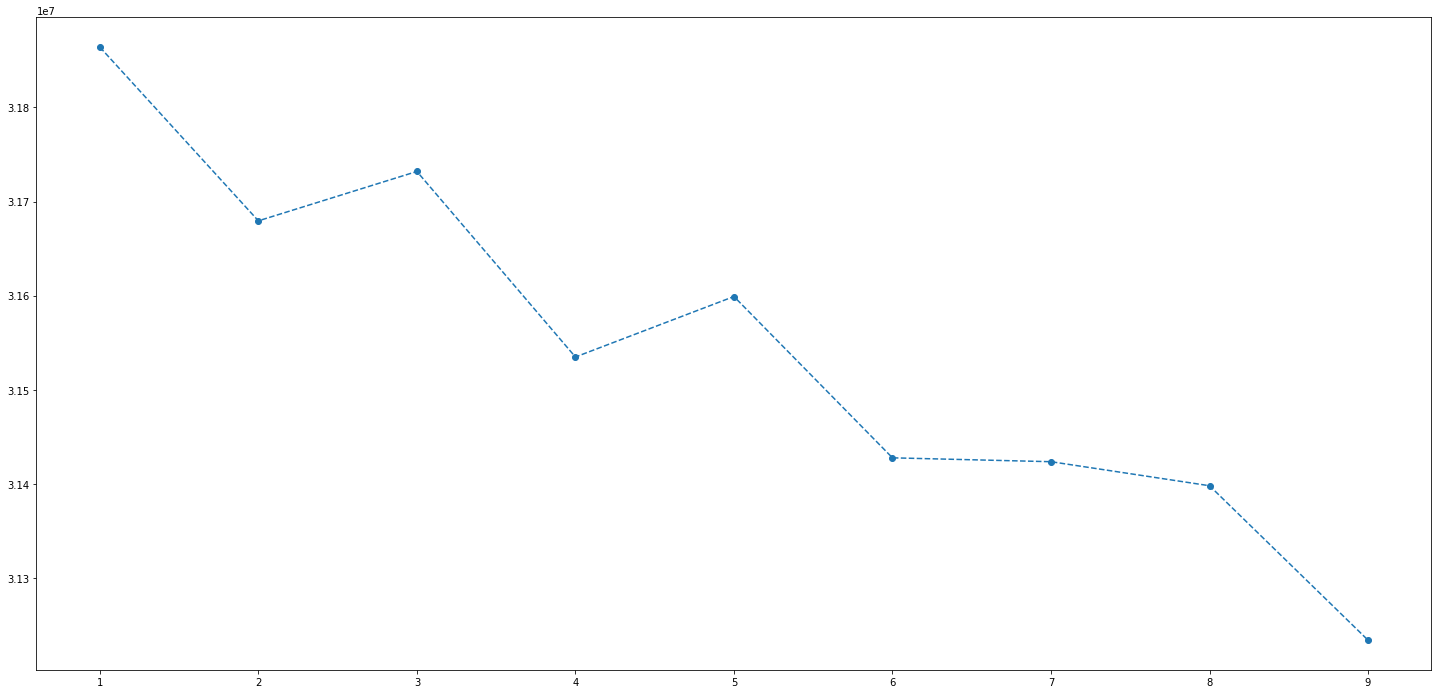

In [522]:
plt.plot(range(1,10), wcss, marker = 'o', linestyle = '--')

In [502]:
# clustering - kmeans

kmeans = KMeans(n_clusters=4, init = 'k-means++', max_iter = 300, random_state=24)
cluster_labels = kmeans.fit(features_pca)

kmeans.labels_

array([2, 2, 2, ..., 0, 0, 0])

In [503]:
cluster_labels

KMeans(n_clusters=4, random_state=24)

In [504]:
sqci2['cluster'] = kmeans.labels_
sqci2.head()

,INSP_DTL_SEQ,INSP_DTL_CODE,VALUE,PROD_SN,DURATION_TIME,PASS_YN,cluster
132,0,AD01,0.000,39DC9029900B620ARAN0002,106,1,2
133,1,AD01,0.000,39DC9029900B620ARAN0002,106,1,2
134,2,AD01,10.000,39DC9029900B620ARAN0002,106,1,2
135,3,AD01,10.000,39DC9029900B620ARAN0002,106,1,2
136,4,AD01,55.000,39DC9029900B620ARAN0002,106,1,2


In [507]:
for i in range(0,4):
    globals()['sqci_cluster_{}'.format(i)] = sqci2[sqci2['cluster'] == i]
    globals()['sqci_cluster_{}_sn'.format(i)] = globals()['sqci_cluster_{}'.format(i)]['PROD_SN'].unique()
    globals()['sqci_cluster_{}_seq'.format(i)] = globals()['sqci_cluster_{}'.format(i)]['INSP_DTL_SEQ'].unique()
    globals()['sqci_cluster_{}_pass_y'.format(i)] = globals()['sqci_cluster_{}'.format(i)][globals()['sqci_cluster_{}'.format(i)]['PASS_YN'] == 1].count()
    globals()['sqci_cluster_{}_pass_n'.format(i)] = globals()['sqci_cluster_{}'.format(i)][globals()['sqci_cluster_{}'.format(i)]['PASS_YN'] == 0].count()
    
print(sqci_cluster_3_sn)
print("------------------------------")
print(sqci_cluster_3_seq)
print("------------------------------")
print(sqci_cluster_3_pass_y)
print("------------------------------")
print(sqci_cluster_3_pass_n)


['39DC9029900B620ARAN0002' '39DC9029900B620ARAN0004'
 '39DC9029900B620ARAN0021' '39DC9029900B620ARAN0027'
 '39DC9029900B620ARAN0034' '39DC9029900B620ARAN0048'
 '39DC9029900B620ARAN0063' '39DC9029900B620ARAN0120'
 '39DC9029900B620ARAN0146' '39DC9029900B620ARAN0184'
 '39DC9029900B620ARAN0195' '39DC9029900B620ARAN0205'
 '39DC9029900B620ARAN0215' '39DC9029900B620ARAN0229'
 '39DC9029900B620ARAX0001' '39DC9029900B620ARAX0008'
 '39DC9029900B620ARAX0038' '39DC9029900B620ARAX0039'
 '39DC9029900B620ARAX0042' '39DC9029900B620ARAX0046'
 '39DC9029900B620ARAX0047' '39DC9029900B620ARAX0049'
 '39DC9029900B620ARAX0069' '39DC9029900B620ARAX0076'
 '39DC9029900B620ARAX0085' '39DC9029900B620ARAX0090'
 '39DC9029900B620ARAX0184' '39DC9029900B620ARAX0207'
 '39DC9029900B620ARAX0208' '39DC9029900B620ARAX0218'
 '39DC9029900B620ARAX0219' '39DC9029900B620ARAX0220'
 '39DC9029900B620ARAX0233' '39DC9029900B620ARAX0235'
 '39DC9029900B620ARAX0244' '39DC9029900B620ARAX0249'
 '39DC9029900B620ARAX0266' '39DC9029900B620ARA

In [69]:
# 평균값
for i in range(0,6):
    print(sqci2[sqci2['cluster'] == i].mean())
    print('------------------------')

C:\Users\gky20\AppData\Local\Temp\ipykernel_18456\939960184.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(sqci2[sqci2['cluster'] == i].mean())


INSP_DTL_SEQ     10.994
VALUE            15.078
DURATION_TIME   180.021
PASS_YN           0.991
cluster           0.000
dtype: float64
------------------------
INSP_DTL_SEQ     24.687
VALUE           532.714
DURATION_TIME   178.850
PASS_YN           0.992
cluster           1.000
dtype: float64
------------------------
INSP_DTL_SEQ     55.000
VALUE             5.656
DURATION_TIME   180.169
PASS_YN           0.992
cluster           2.000
dtype: float64
------------------------
INSP_DTL_SEQ     52.001
VALUE           505.972
DURATION_TIME   180.174
PASS_YN           0.992
cluster           3.000
dtype: float64
------------------------
INSP_DTL_SEQ      5.207
VALUE           184.170
DURATION_TIME   183.051
PASS_YN           0.991
cluster           4.000
dtype: float64
------------------------
INSP_DTL_SEQ     33.500
VALUE             8.173
DURATION_TIME   180.169
PASS_YN           0.992
cluster           5.000
dtype: float64
------------------------


# value와 y/n 상관관계

In [89]:
sqci.head()

,INSP_DTL_SEQ,INSP_CODE,INSP_DTL_CODE,VALUE,HEADER,IP_ADDRESS,PROD_SN,START_TIME,END_TIME,PASS_YN,INSP_NUM,DURATION_TIME
0,0,RT02,AD01,0.000,CPC,0.0.0.102,39DC9029900B620ARAN0001,20211022115325,20211022115430,Y,2,105
1,1,RT02,AD01,0.000,CPC,0.0.0.102,39DC9029900B620ARAN0001,20211022115325,20211022115430,Y,2,105
2,2,RT02,AD01,7.000,CPC,0.0.0.102,39DC9029900B620ARAN0001,20211022115325,20211022115430,Y,2,105
3,3,RT02,AD01,36.000,CPC,0.0.0.102,39DC9029900B620ARAN0001,20211022115325,20211022115430,Y,2,105
4,4,RT02,AD01,36.000,CPC,0.0.0.102,39DC9029900B620ARAN0001,20211022115325,20211022115430,Y,2,105


In [104]:
sqci3 = sqci[['INSP_DTL_SEQ', 'INSP_DTL_CODE', 'VALUE', 'PROD_SN', 'START_TIME', 'END_TIME', 'PASS_YN', 'DURATION_TIME']]
sqci3['PASS_YN'] = sqci3['PASS_YN'].map({'Y':1,
                                         'N':0})
sqci3['INSP_DTL_CODE'] = sqci3['INSP_DTL_CODE'].map({'AD01':1,
                                                    'AD02':2})

In [105]:
sqci3.head()

,INSP_DTL_SEQ,INSP_DTL_CODE,VALUE,PROD_SN,START_TIME,END_TIME,PASS_YN,DURATION_TIME
0,0,1,0.000,39DC9029900B620ARAN0001,20211022115325,20211022115430,1,105
1,1,1,0.000,39DC9029900B620ARAN0001,20211022115325,20211022115430,1,105
2,2,1,7.000,39DC9029900B620ARAN0001,20211022115325,20211022115430,1,105
3,3,1,36.000,39DC9029900B620ARAN0001,20211022115325,20211022115430,1,105
4,4,1,36.000,39DC9029900B620ARAN0001,20211022115325,20211022115430,1,105


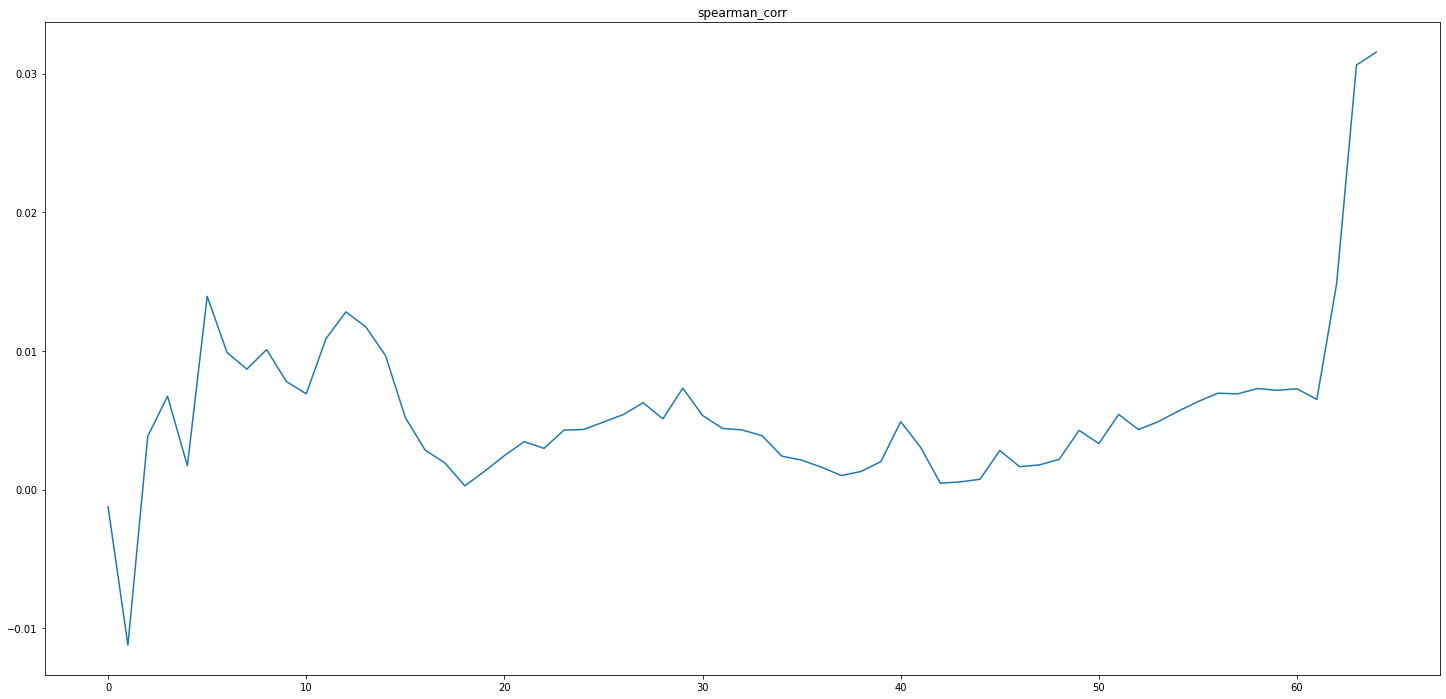

In [418]:
# spearman corr

cor_list = []
for i in range(0,65):
    # 각 seq당 sn의 value mapping
    globals()['sqci_{}'.format(i)] = sqci3[sqci3['INSP_DTL_SEQ'] == i]
    cor, pval = stats.spearmanr(globals()['sqci_{}'.format(i)]['VALUE'], globals()['sqci_{}'.format(i)]['PASS_YN'])
    cor_list.append(cor)

cor_list = pd.DataFrame(cor_list)
cor_list.rename(columns= {0 : 'spearman_corr'}, inplace = True)
#cor_list

plt.plot(cor_list['spearman_corr'])
plt.title('spearman_corr')
plt.show()

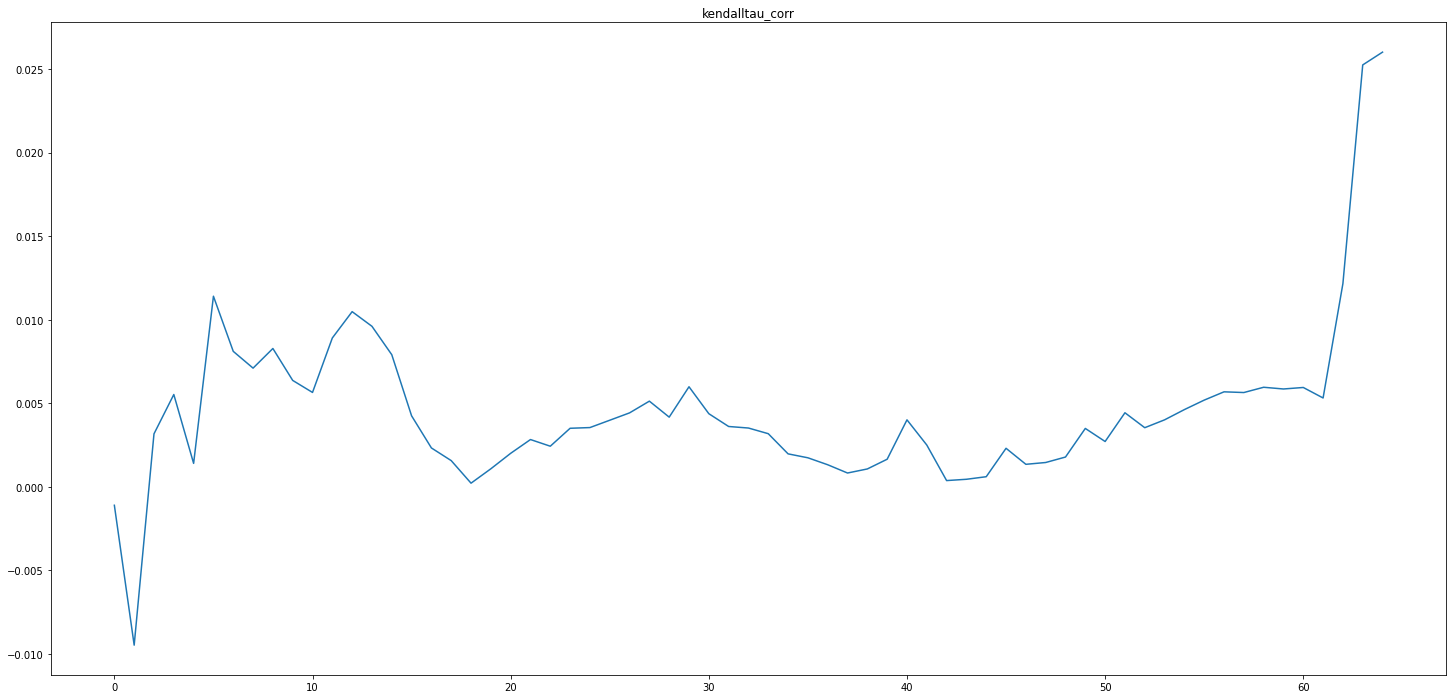

In [417]:
# kendalltau corr
cor_list2 = []
for i in range(0,65):
    # 각 seq당 sn의 value mapping
    globals()['sqci_{}'.format(i)] = sqci3[sqci3['INSP_DTL_SEQ'] == i]
    cor2, pval2 = stats.kendalltau(globals()['sqci_{}'.format(i)]['VALUE'], globals()['sqci_{}'.format(i)]['PASS_YN'])
    cor_list2.append(cor2)

cor_list2 = pd.DataFrame(cor_list2)
cor_list2.rename(columns= {0 : 'kendalltau_corr'}, inplace = True)
#cor_list1

plt.plot(cor_list2['kendalltau_corr'])
plt.title('kendalltau_corr')
plt.show()

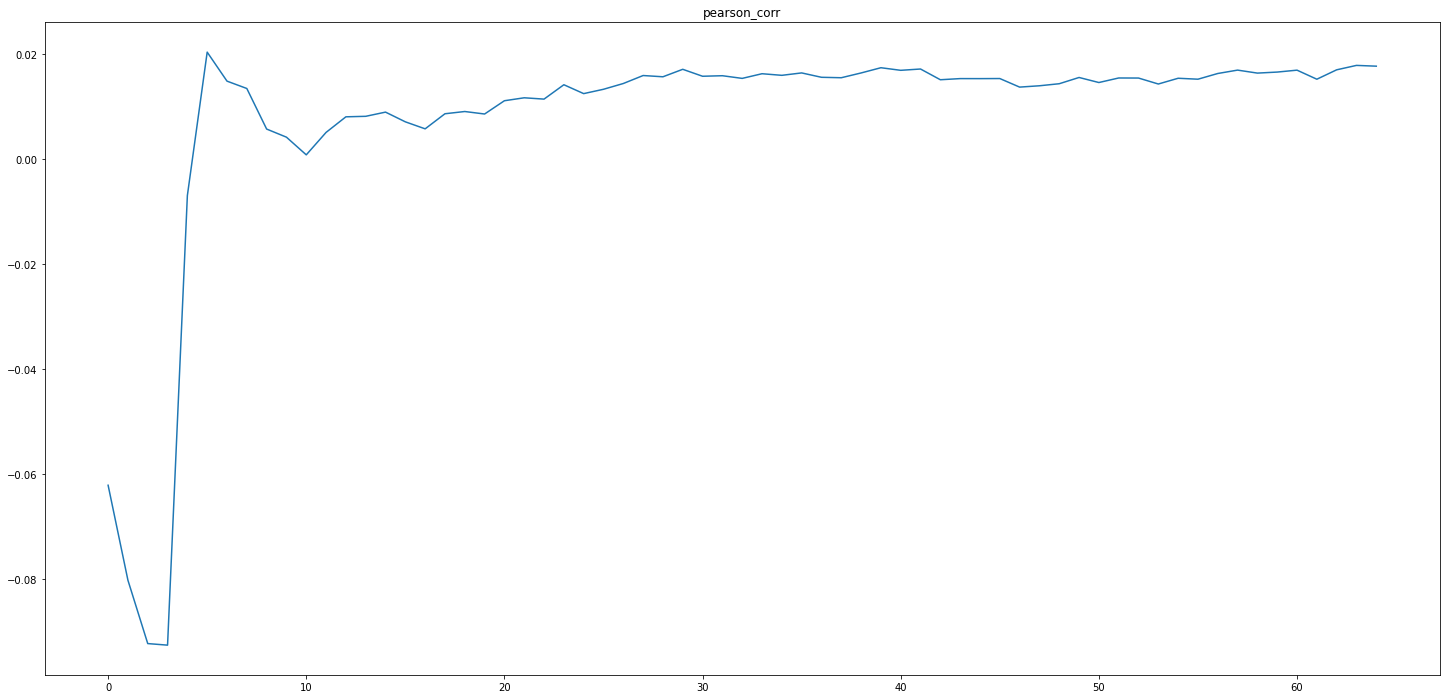

In [416]:
# pearson corr
cor_list1 = []
for i in range(0,65):
    # 각 seq당 sn의 value mapping
    globals()['sqci_{}'.format(i)] = sqci3[sqci3['INSP_DTL_SEQ'] == i]
    cor1, pval1 = stats.pearsonr(globals()['sqci_{}'.format(i)]['VALUE'], globals()['sqci_{}'.format(i)]['PASS_YN'])
    cor_list1.append(cor1)

cor_list1 = pd.DataFrame(cor_list1)
cor_list1.rename(columns= {0 : 'pearson_corr'}, inplace = True)
#cor_list1

plt.plot(cor_list1['pearson_corr'])
plt.title('pearson_corr')
plt.show()

## Value BARPLOT, VIOLINPLOT

In [390]:
# AD01
sqci3_1 = sqci3[sqci3['INSP_DTL_CODE'] == 1]
# AD02
sqci3_2 = sqci3[sqci3['INSP_DTL_CODE'] == 2]

In [ ]:
plt.bar(sqci3['INSP_DTL_SEQ'], sqci3_2'VALUE'])
plt.show()

In [ ]:
plt.bar(sqci3_1['INSP_DTL_SEQ'], sqci3_1['VALUE'])
plt.show()

In [ ]:
plt.bar(sqci3_2['INSP_DTL_SEQ'], sqci3_2['VALUE'])
plt.show()

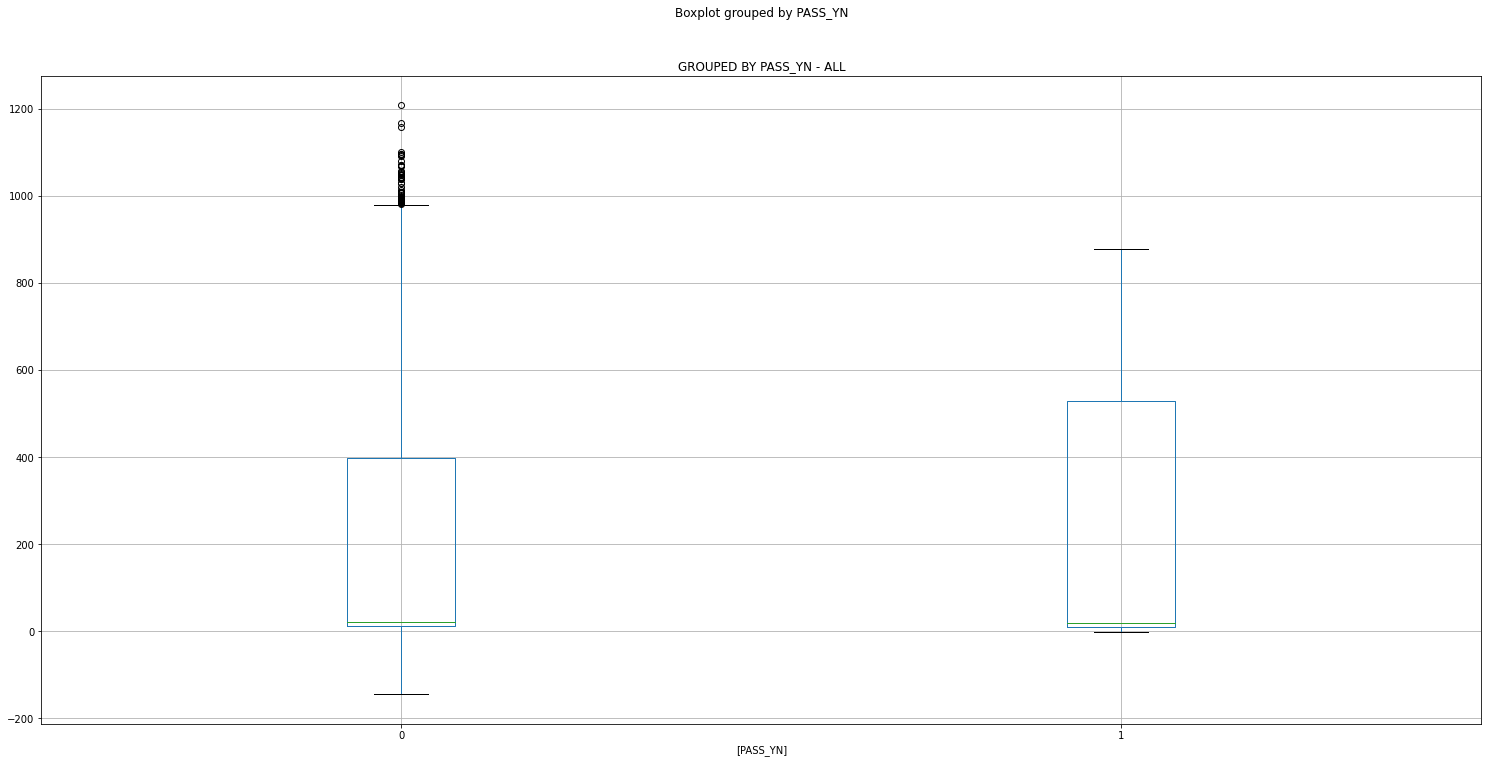

In [401]:
# ALL - box
sqci3[['VALUE', 'PASS_YN']].boxplot(by = 'PASS_YN')
plt.title('GROUPED BY PASS_YN - ALL')
plt.show()

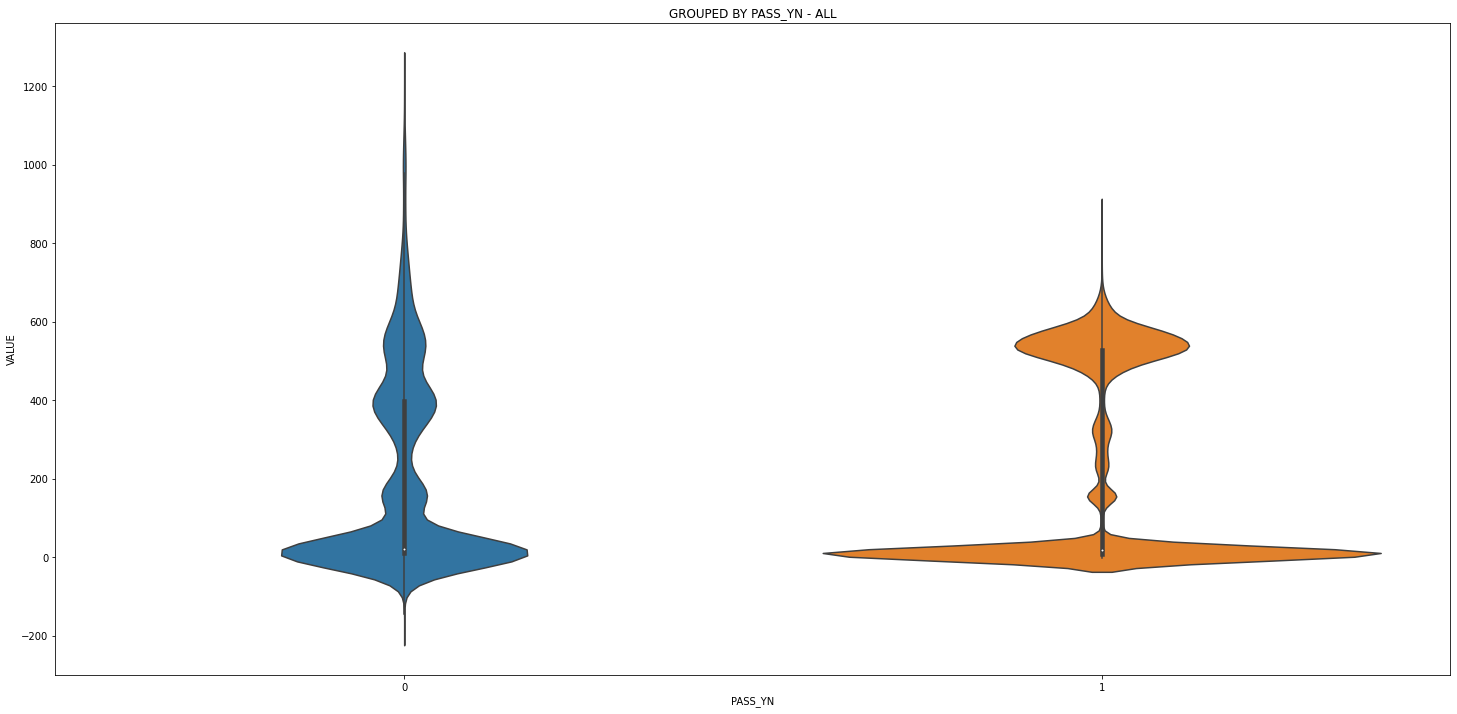

In [513]:
# ALL
sns.violinplot(data=sqci3, x="PASS_YN", y="VALUE")
#sns.swarmplot(data=sqci3, x="PASS_YN", y="VALUE")
plt.title("GROUPED BY PASS_YN - ALL")
plt.show() 

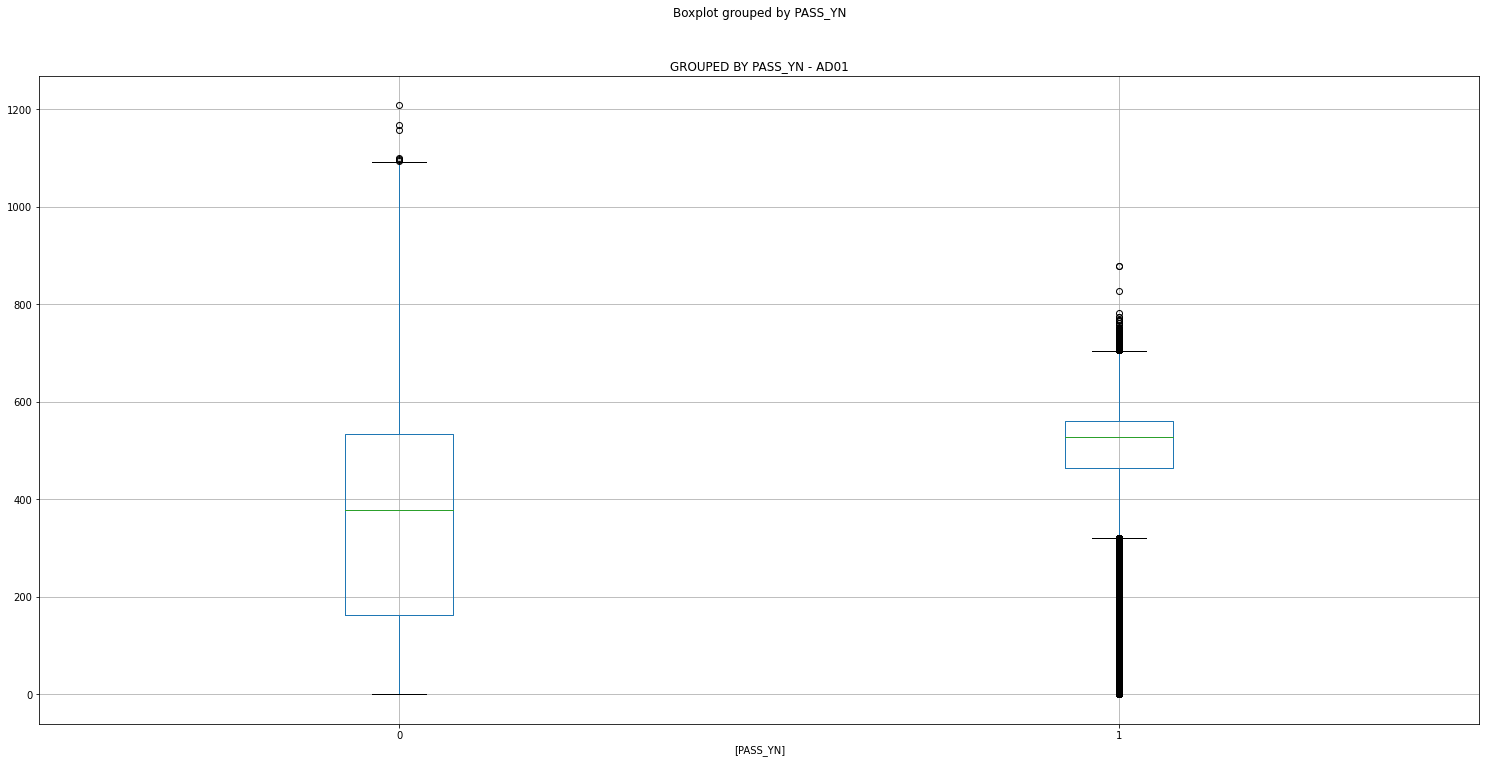

In [395]:
# AD01
sqci3_1[['VALUE', 'PASS_YN']].violinplot(by = 'PASS_YN')
plt.title('GROUPED BY PASS_YN - AD01')
plt.show()

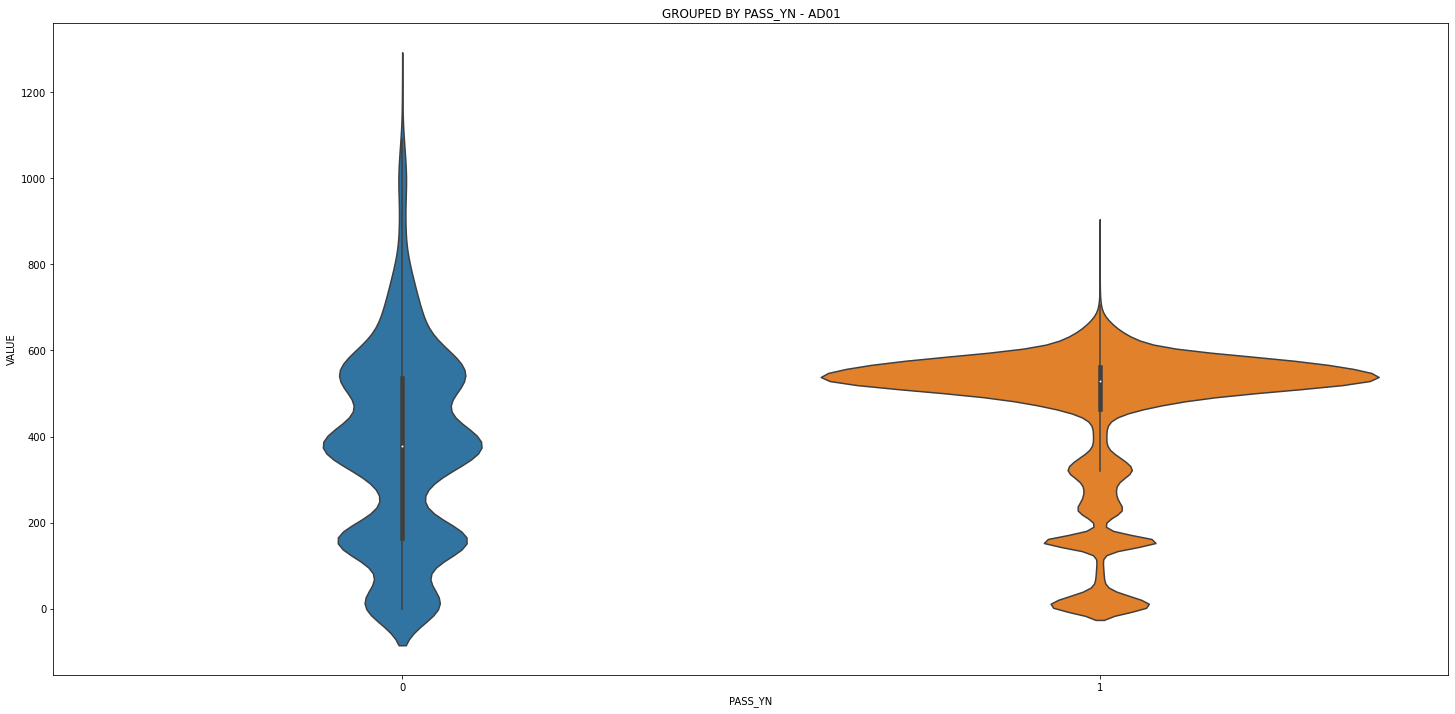

In [514]:
# AD01 - viloinplot
sns.violinplot(data=sqci3_1, x="PASS_YN", y="VALUE")
#sns.swarmplot(data=sqci3_1, x="PASS_YN", y="VALUE")
plt.title('GROUPED BY PASS_YN - AD01')
plt.show() 

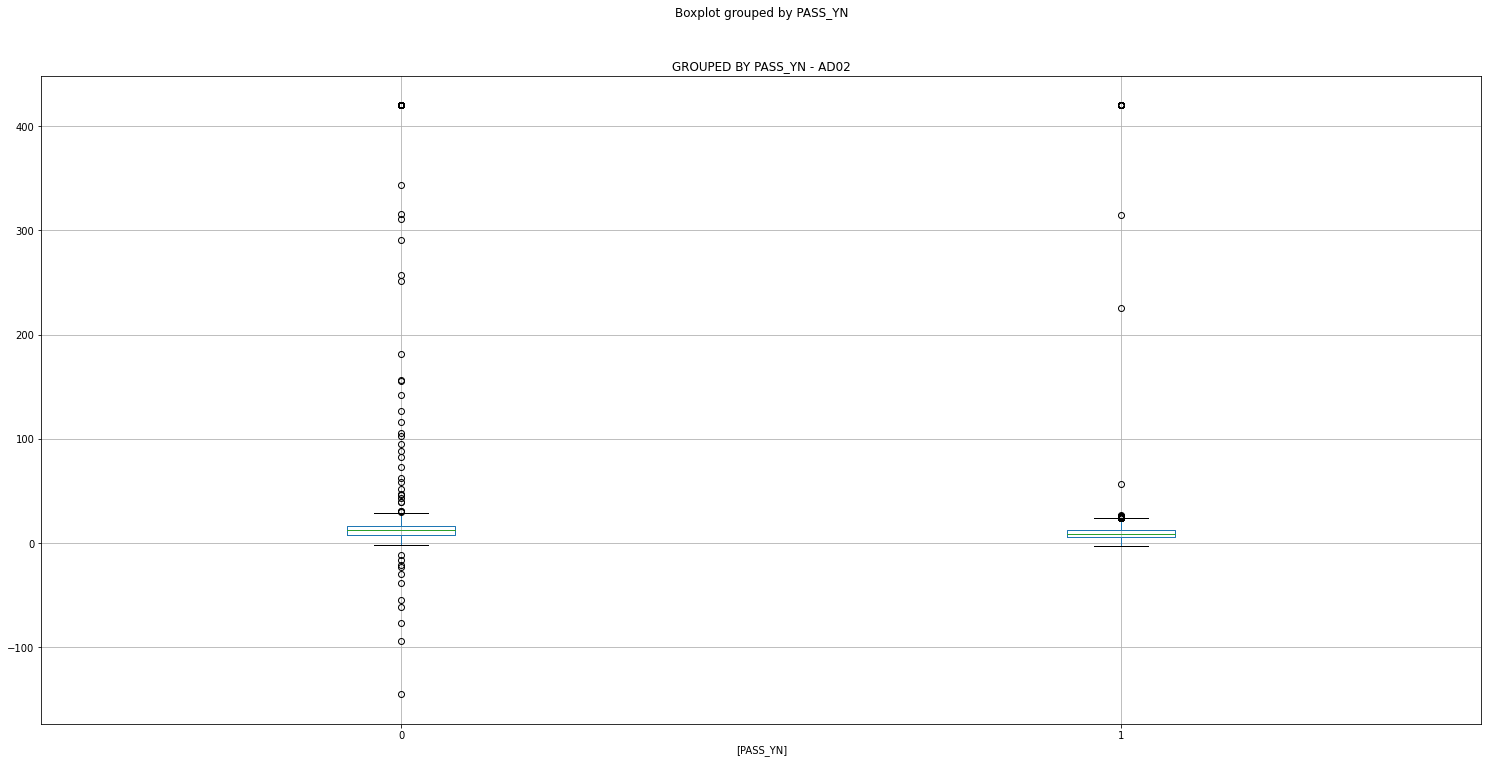

In [396]:
# AD02
sqci3_2[['VALUE', 'PASS_YN']].boxplot(by = 'PASS_YN')
plt.title('GROUPED BY PASS_YN - AD02')
plt.show()

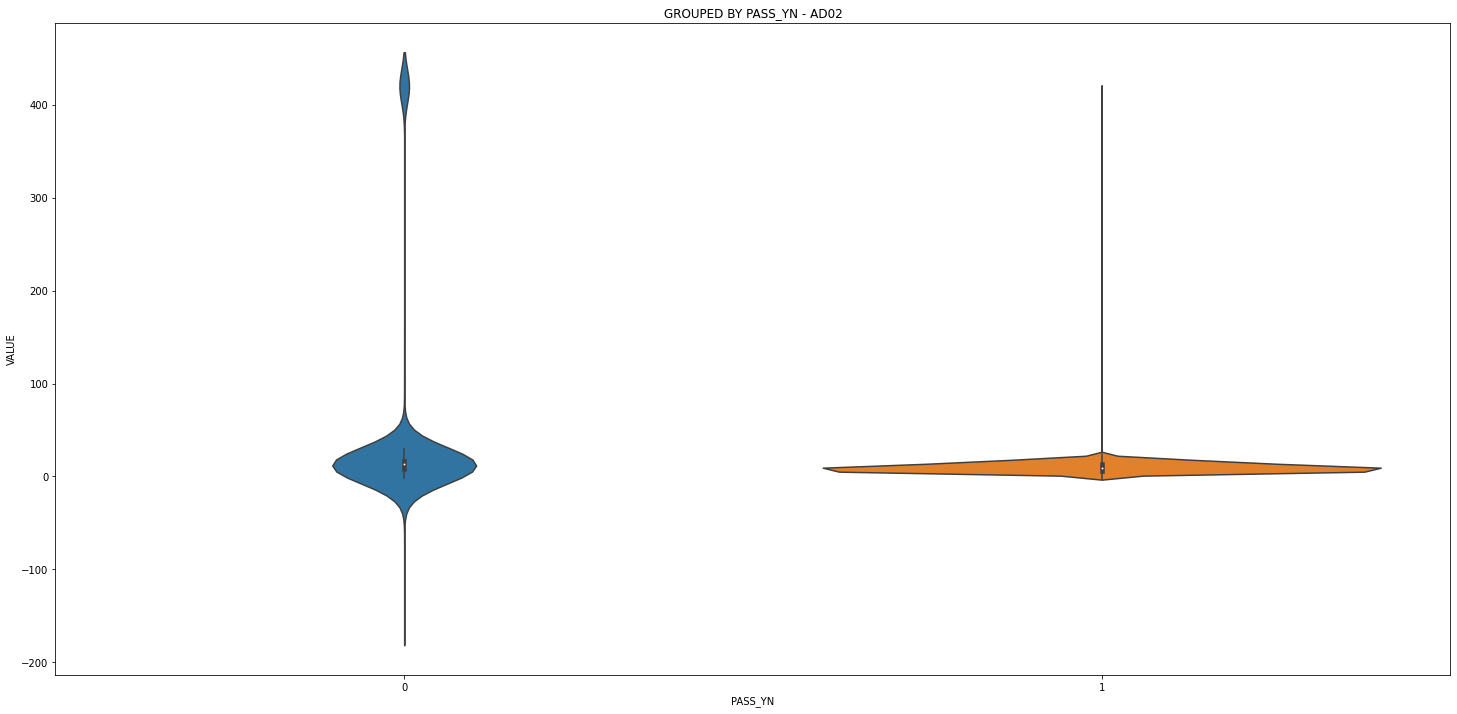

In [515]:
# AD02 - viloinplot
sns.violinplot(data=sqci3_2, x="PASS_YN", y="VALUE")
#sns.swarmplot(data=sqci3_2, x="PASS_YN", y="VALUE")
plt.title('GROUPED BY PASS_YN - AD02')
plt.show() 

## t-test을 통한 통계적으로 유의미한 차이 유무 탐색

In [478]:
sqci_ad01 = sqci3[sqci3['INSP_DTL_CODE'] == 1][['PROD_SN','INSP_DTL_SEQ', 'VALUE', 'PASS_YN']]
sqci_ad02 = sqci3[sqci3['INSP_DTL_CODE'] == 2][['PROD_SN','INSP_DTL_SEQ', 'VALUE', 'PASS_YN']]
sqci_ad01_y = sqci3[(sqci3['INSP_DTL_CODE'] == 1) & (sqci3['PASS_YN'] == 1)][['VALUE']]
#sqci_ad01_y = sqci_ad01_y.values.tolist()
sqci_ad01_n = sqci3[(sqci3['INSP_DTL_CODE'] == 1) & (sqci3['PASS_YN'] == 0)][['VALUE']]
#sqci_ad01_n = sqci_ad01_n.values.tolist()
sqci_ad02_y = sqci3[(sqci3['INSP_DTL_CODE'] == 2) & (sqci3['PASS_YN'] == 1)][['VALUE']]
#sqci_ad02_y = sqci_ad02_y.values.tolist()
sqci_ad02_n = sqci3[(sqci3['INSP_DTL_CODE'] == 2) & (sqci3['PASS_YN'] == 0)][['VALUE']]
#sqci_ad02_n = sqci_ad02_n.values.tolist()

### VALUE값에 따른 PASS_YN 여부

In [479]:
# Y
stats.ttest_ind(sqci_ad01_y, sqci_ad02_y, equal_var=False)

Ttest_indResult(statistic=array([1570.67769247]), pvalue=array([0.]))

In [480]:
# N
stats.ttest_ind(sqci_ad01_n, sqci_ad02_n, equal_var=False)

Ttest_indResult(statistic=array([88.82243864]), pvalue=array([0.]))

## 분포 그래프


## 시장 prod_sn

In [73]:
defective_mkt_product=pd.read_csv('MARKET_SN.txt')

In [74]:
defective_mkt_product.head()

,MARKET_SN
0,39DC9028176A620ANC20378
1,39DC9028176A620ANCZ0254
2,39DC9028176A620AR290628
3,39DC9028176A620ANC50552
4,39DC9025644B620ANBK0291


In [75]:
sqci_mkt=pd.merge(sqci,defective_mkt_product,how='left',left_on='PROD_SN',right_on='MARKET_SN')

In [76]:
sqci_mkt.head()

,INSP_DTL_SEQ,INSP_CODE,INSP_DTL_CODE,VALUE,HEADER,IP_ADDRESS,PROD_SN,START_TIME,END_TIME,PASS_YN,INSP_NUM,DURATION_TIME,MARKET_SN
0,0,RT02,AD01,0.000,CPC,0.0.0.102,39DC9029900B620ARAN0001,20211022115325,20211022115430,Y,2,105,NaN
1,1,RT02,AD01,0.000,CPC,0.0.0.102,39DC9029900B620ARAN0001,20211022115325,20211022115430,Y,2,105,NaN
2,2,RT02,AD01,7.000,CPC,0.0.0.102,39DC9029900B620ARAN0001,20211022115325,20211022115430,Y,2,105,NaN
3,3,RT02,AD01,36.000,CPC,0.0.0.102,39DC9029900B620ARAN0001,20211022115325,20211022115430,Y,2,105,NaN
4,4,RT02,AD01,36.000,CPC,0.0.0.102,39DC9029900B620ARAN0001,20211022115325,20211022115430,Y,2,105,NaN


In [77]:
sqci_mkt.dropna()

,INSP_DTL_SEQ,INSP_CODE,INSP_DTL_CODE,VALUE,HEADER,IP_ADDRESS,PROD_SN,START_TIME,END_TIME,PASS_YN,INSP_NUM,DURATION_TIME,MARKET_SN


### =>NO matching MARKET_SN with INSP_DTL_CODE